<div style="text-align: center;">
    <h1>What do your blood sugars tell you?</h1>
</div>

<div style="text-align: center;">
    <img src="images/diabetes.jpg" alt="Diabetes" width="600">
</div>


## 📖 Background

Diabetes mellitus remains a global health issue, causing several thousand people to die each day from this single condition. Finding and avoiding diabetes in the earlier stages can help reduce the risk of serious health issues such as circulatory system diseases, kidney malfunction, and vision loss. This competition involves developing a predictive model for effectively detecting potential Diabetes cases, ideally, before commencing preventive treatment.

## 🎯 Project Objectives

The objectives of this project are as follows:

1. **Identify Key Factors**: Perform an exploratory data analysis (EDA) to determine the most important factors influencing diabetes outcomes.
   
2. **Visualize Relationships**: Create interactive plots to visualize the relationships between diabetes and the key factors identified from the EDA.

3. **Develop a Predictive Model**: Build a robust predictive model to assess the risk of developing diabetes, using the insights gained from the EDA and visualizations.

4. **Build a GUI**: Build a GUI the end users, namely doctors and healthcare professionals, or anyone interested in learning their risk level, can easily use to assess their patient's risks of developing diabetes.

## 📋 Table of Contents

- [The Dataset](#-the-dataset)
- [Data Preprocessing](#-data-preprocessing)
- [Exploratory Data Analysis](#-exploratory-data-analysis--eda--)
- [Modelling](#-modelling)

## 💾 The Dataset

This dataset contains diagnostic measurements related to diabetes, collected from a population of **768 Pima Indian women**. It includes various medical and demographic attributes described below.

| Column Name                | Data Type                | Description                                                                                       |
|----------------------------|--------------------------|---------------------------------------------------------------------------------------------------|
| **Pregnancies**            | Numerical (Continuous)   | Number of times the patient has been pregnant.                                                    |
| **Glucose**                | Numerical (Continuous)   | Plasma glucose concentration after 2 hours in an oral glucose tolerance test.                     |
| **BloodPressure**          | Numerical (Continuous)   | Diastolic blood pressure (mm Hg).                                                                 |
| **SkinThickness**          | Numerical (Continuous)   | Triceps skinfold thickness (mm).                                                                  |
| **Insulin**                | Numerical (Continuous)   | 2-Hour serum insulin (mu U/ml).                                                                   |
| **BMI**                    | Numerical (Continuous)   | Body mass index (weight in kg/(height in m)^2).                                                   |
| **DiabetesPedigreeFunction** | Numerical (Continuous) | A function that represents the likelihood of diabetes based on family history.                    |
| **Age**                    | Numerical (Continuous)   | Age of the patient in years.                                                                      |
| **Outcome**                | Categorical (Binary)     | Class variable (0 or 1) indicating whether the patient is diagnosed with diabetes. (1 = Yes, 0 = No) |

In [1]:
# Importing libraries for entire notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import IPython.display as display
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix, f1_score, classification_report, precision_score, recall_score, precision_recall_curve, auc, fbeta_score, log_loss, silhouette_score
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.dummy import DummyClassifier
import math

data = pd.read_csv('data/diabetes.csv')
# Display the first few rows of the DataFrame
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

## 🔄 Data Preprocessing

- Before we try to answer any questions, let's look at the distribution of variables to see how balanced the dataset is.

- We will also deal with anomalies, potentially remove some outliers, normalize the data and conduct some preliminary EDA before diving deeper into the data.

### 📊 Data Distribution

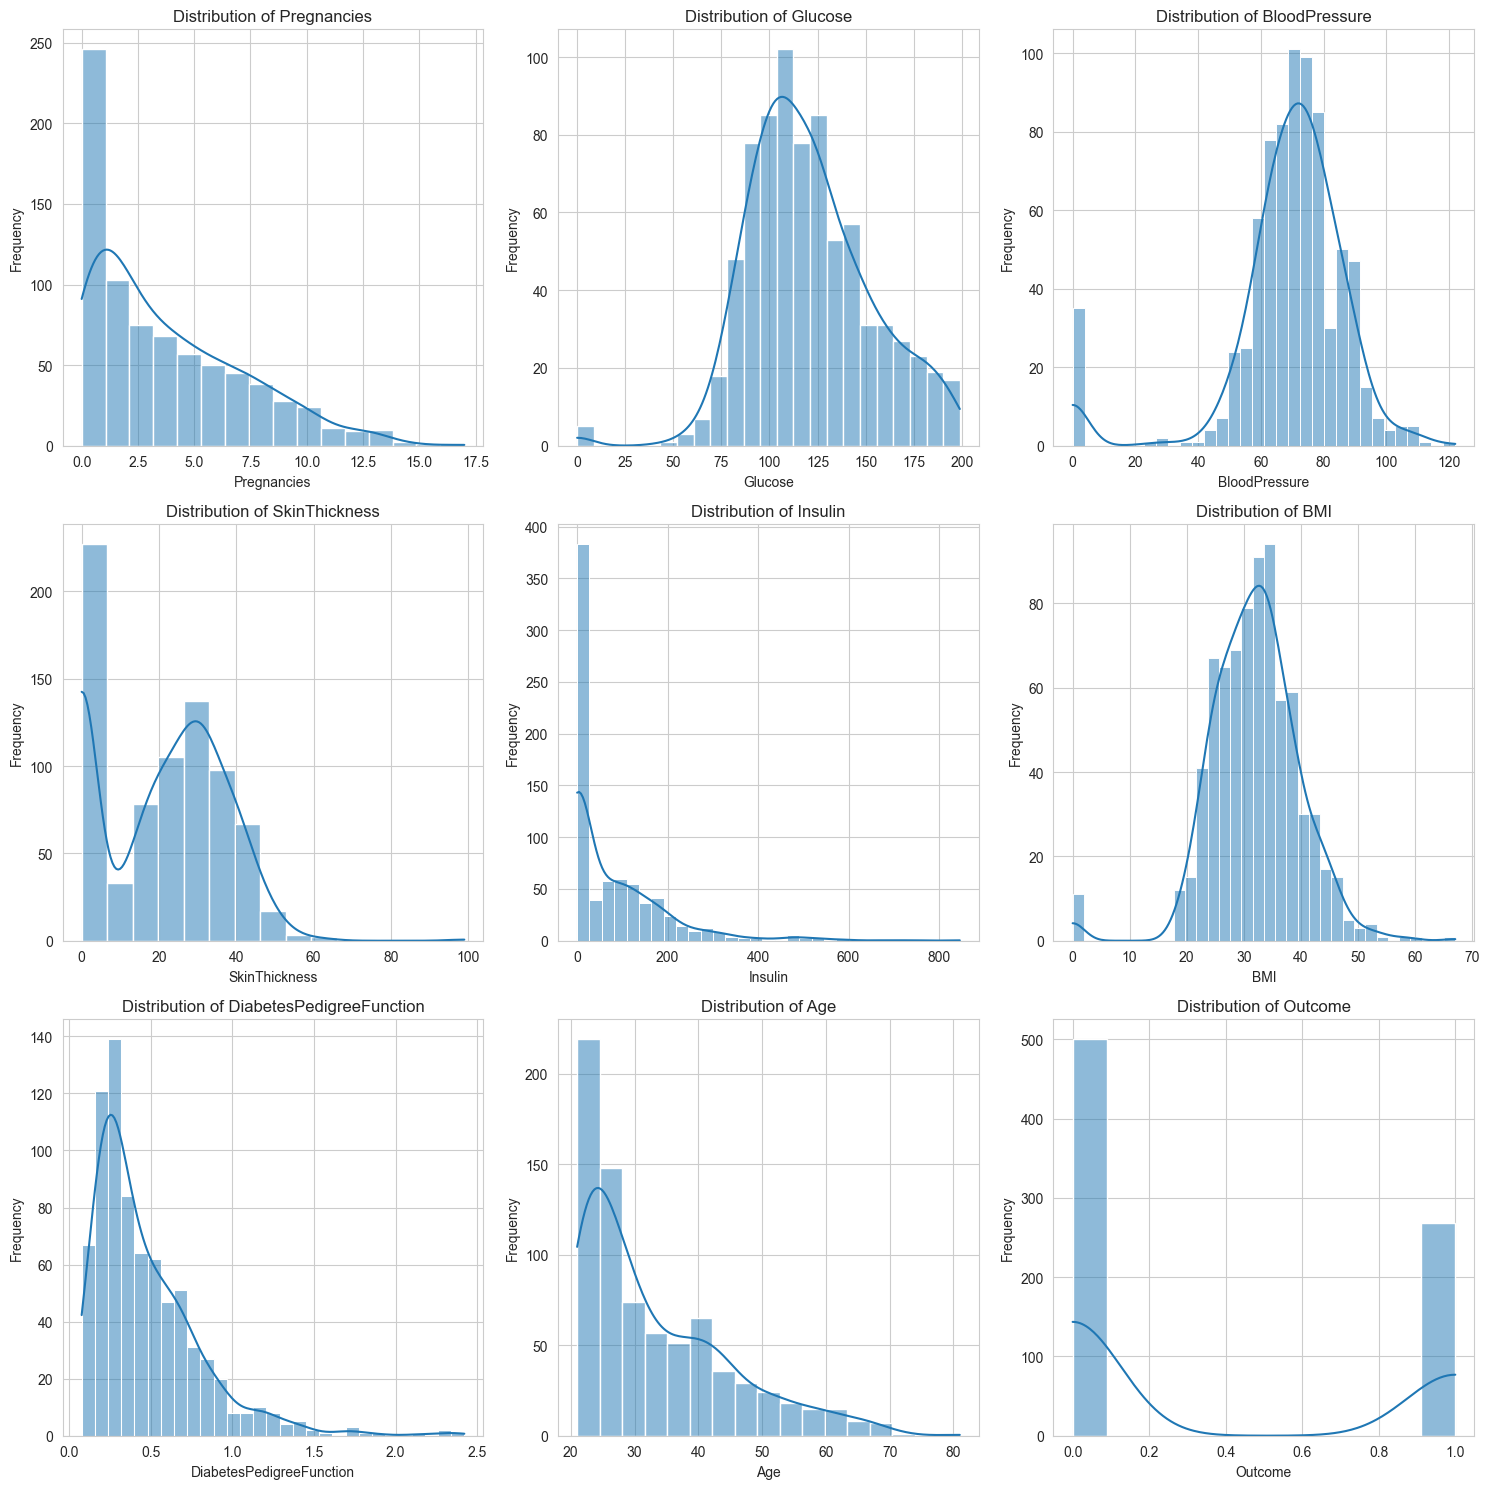

In [2]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# List of columns to plot
columns = data.columns

# Plot the distribution of each variable
for i, col in enumerate(columns):
    sns.histplot(data[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

**Inference**:<br>
<br>

- `Glucose`, `BloodPressure`, `SkinThickness`, `BMI`, `DiabetesPedigreeFunction` have Gaussian-like distributions.<br>
<br>
-  `Age`, `Pregnancies`, have exponential distributions.<br>
<br>


- We can also notice a lot of anomalies; we have aggregate of values at 0 where we should not. Unless this data was obtained from dead women or women suffering from severe third degree burning, having a `BloodPressure`, `Glucose` level, `BMI`, or `SkinThickness` of 0 is impossible or highly unlikely at best. It is more likely that most of these are missing values.<br>
<br>

- `Insulin` also has a suspicious amount of 0. Having amounts of insulin so low they are not detectable could be possible. However, it is unlikely that it is the case for over half the population. This makes dropping the rows not feasible, and makes an imputation that does not introduce any bias difficult. For now, we will keep it as is, but we should strongly consider dropping this feature.

In [3]:
# Create a dictionary to store the number of zeros in each column
zero_counts = {col: (data[col] == 0).sum() for col in data.columns}

# Convert the dictionary to a DataFrame
zero_counts_df = pd.DataFrame(list(zero_counts.items()), columns=['Column', 'Zero Count'])

# Transpose the DataFrame
zero_counts_transposed_df = zero_counts_df.set_index('Column').T

# Display the transposed DataFrame as a table
display.display(zero_counts_transposed_df)

Column      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  \
Zero Count          111        5             35            227      374   11   

Column      DiabetesPedigreeFunction  Age  Outcome  
Zero Count                         0    0      500

### 🧹 Data Cleaning

Given the limited amount of data available and the sometimes numerous wrong values, simply dropping them is not necessarily the best option. Here is how we will deal with each of these variables:

- `Glucose`: 5 missing values (0.65% of data). They will be dropped.
- `BMI`: 11 missing values (1.43% of data). They will be dropped.
- `BloodPressure`: 35 missing values (4.56% of data). Let's take a look at how this variable, for non-zero values, relates to Diabetes and other variables.
- `SkinThickness`: 227 missing values. Let's also take a quick look at how this variable, when non-zero, relates to Diabetes and other variables.

In [4]:
# Drop rows where 'Glucose' or 'BMI' column has a value of 0
data = data[(data['Glucose'] != 0) & (data['BMI'] != 0)]
print('Dropped missing values for Glucose and BMI.\n')

# Also drop an outlier for SkinThickness noticed during K-means clustering
data = data[data['SkinThickness'] <= 95]
print('Dropped SkinThickness outlier (SkinThickness>95).\n')

# SkinThickness and BloodPressure:

# Remove rows where 'SkinThickness' or 'BloodPressure' is 0
filtered_data = data[(data['SkinThickness'] != 0) & (data['BloodPressure'] != 0)]

def calculate_correlation_and_pvalue(df, col1, col2):
    corr, p_value = stats.pearsonr(df[col1], df[col2])
    return corr, p_value

# List of columns to test against
columns_to_test = [col for col in filtered_data.columns if col not in ['SkinThickness', 'BloodPressure']]

# Calculate correlations and p-values for SkinThickness
skin_results = []
for col in columns_to_test:
    skin_corr, skin_pvalue = calculate_correlation_and_pvalue(filtered_data, 'SkinThickness', col)
    skin_results.append([col, skin_corr, skin_pvalue])

# Calculate correlations and p-values for BloodPressure
bp_results = []
for col in columns_to_test:
    bp_corr, bp_pvalue = calculate_correlation_and_pvalue(filtered_data, 'BloodPressure', col)
    bp_results.append([col, bp_corr, bp_pvalue])

# Create DataFrames for SkinThickness and BloodPressure
skin_df = pd.DataFrame(skin_results, columns=['Column', 'Correlation', 'p-value'])
bp_df = pd.DataFrame(bp_results, columns=['Column', 'Correlation', 'p-value'])

# Set Column as index and transpose
skin_df_transposed = skin_df.set_index('Column').T
bp_df_transposed = bp_df.set_index('Column').T

# Display the transposed DataFrames
import IPython.display as display

print("SkinThickness Correlation and p-value Table:")
display.display(skin_df_transposed)

print("\nBloodPressure Correlation and p-value Table:")
display.display(bp_df_transposed)

Dropped missing values for Glucose and BMI.

Dropped SkinThickness outlier (SkinThickness>95).

SkinThickness Correlation and p-value Table:


Column       Pregnancies   Glucose   Insulin           BMI  \
Correlation     0.105305  0.205762  0.144171  6.727094e-01   
p-value         0.015198  0.000002  0.000863  3.205082e-71   

Column       DiabetesPedigreeFunction       Age       Outcome  
Correlation                  0.121163  0.132576  2.481387e-01  
p-value                      0.005178  0.002204  6.816896e-09


BloodPressure Correlation and p-value Table:


Column       Pregnancies       Glucose   Insulin           BMI  \
Correlation     0.204601  2.210024e-01  0.006842  3.074420e-01   
p-value         0.000002  2.683809e-07  0.875019  4.356302e-13   

Column       DiabetesPedigreeFunction           Age   Outcome  
Correlation                  0.008096  3.502393e-01  0.184109  
p-value                      0.852349  9.055335e-17  0.000020

- The correlation between `Outcome` with both `BloodPressure` and `SkinThickness` is not negligible. Missing values therefore need to be handled carefully. 
- `BloodPressure` is correlated to `Age`, `BMI`, `Glucose` and `Pregnancies`.
- `SkinThickness` is correlated to `BMI`, and `Glucose`.

Using a regression imputatation strategy could work well for `SkinThickness`, as it has a strong correlation to `BMI`, and moderate correlation to `Outcome`.
It is less clear that this strategy would work well for `BloodPressure` as it has no strong correlations and only moderate correlations to `BMI` and `Age`. 

We will compare how regression models, KNN models and RF models perform for `BloodPressure` and `SkinThickness` to decide the way to impute them.

In [5]:
# Get the zeros
zero_skinthickness = data['SkinThickness'] == 0
zero_bloodpressure = data['BloodPressure'] == 0

# Filter the data for valid entries (non-zero rows)
filtered_df_skinthickness = data[~zero_skinthickness].reset_index(drop=True)
filtered_df_bloodpressure = data[~zero_bloodpressure].reset_index(drop=True)

# Build Regression Models for SkinThickness and BloodPressure

# Defining predictors
predictors_st = ['Glucose', 'BMI', 'Outcome', 'Age']
predictors_bp = ['Age', 'BMI', 'Pregnancies', 'Glucose', 'Outcome']

# Regression models
reg_model_skinthickness = LinearRegression()
reg_model_skinthickness.fit(filtered_df_skinthickness[predictors_st], filtered_df_skinthickness['SkinThickness'])

reg_model_bloodpressure = LinearRegression()
reg_model_bloodpressure.fit(filtered_df_bloodpressure[predictors_bp], filtered_df_bloodpressure['BloodPressure'])

# Evaluate performance on non-zero values to see how well predicions match real values

# Predictions on non-zero data
predictions_skinthickness = reg_model_skinthickness.predict(filtered_df_skinthickness[predictors_st])
predictions_bloodpressure = reg_model_bloodpressure.predict(filtered_df_bloodpressure[predictors_bp])

# Performance metrics
mae_skinthickness = mean_absolute_error(filtered_df_skinthickness['SkinThickness'], predictions_skinthickness)
mse_skinthickness = mean_squared_error(filtered_df_skinthickness['SkinThickness'], predictions_skinthickness)
r2_skinthickness = r2_score(filtered_df_skinthickness['SkinThickness'], predictions_skinthickness)

mae_bloodpressure = mean_absolute_error(filtered_df_bloodpressure['BloodPressure'], predictions_bloodpressure)
mse_bloodpressure = mean_squared_error(filtered_df_bloodpressure['BloodPressure'], predictions_bloodpressure)
r2_bloodpressure = r2_score(filtered_df_bloodpressure['BloodPressure'], predictions_bloodpressure)

# Printing the performance metrics
print("SkinThickness Regression Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_skinthickness:.4f}")
print(f"Mean Squared Error (MSE): {mse_skinthickness:.4f}")
print(f"R-squared (R2): {r2_skinthickness:.4f}")

print("\nBloodPressure Regression Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_bloodpressure:.4f}")
print(f"Mean Squared Error (MSE): {mse_bloodpressure:.4f}")
print(f"R-squared (R2): {r2_bloodpressure:.4f}")

# Initialize lists to store MAE and MSE for each k
mae_skinthickness_knn = []
mse_skinthickness_knn = []
mae_bloodpressure_knn = []
mse_bloodpressure_knn = []

# Define range of k values to test
k_values = range(1, 21)  # Testing KNN with k from 1 to 20

# Iterate over different k values
for k in k_values:
    # Prepare KNN Regressor
    knn_regressor_st = KNeighborsRegressor(n_neighbors=k)
    knn_regressor_bp = KNeighborsRegressor(n_neighbors=k)
    
    # For SkinThickness
    predictions_skinthickness_knn = []
    actual_skinthickness = filtered_df_skinthickness['SkinThickness'].values

    for i in range(len(filtered_df_skinthickness)):  # We use Leave-One-Out Cross-Validation (LOOCV)
        # Create dataset for KNN regression excluding the i-th row
        train_df = filtered_df_skinthickness.drop(index=i)
        train_X = train_df[predictors_st]
        train_y = train_df['SkinThickness']
        
        # Fit KNN model on training data
        knn_regressor_st.fit(train_X, train_y)
        test_X = filtered_df_skinthickness[predictors_st].iloc[[i]]
        
        # Predict the missing value
        predicted_value = knn_regressor_st.predict(test_X)[0]  # Extract predicted value
        
        predictions_skinthickness_knn.append(predicted_value)
    
    # Compute MAE and MSE for SkinThickness
    mae_skinthickness_knn.append(mean_absolute_error(actual_skinthickness, predictions_skinthickness_knn))
    mse_skinthickness_knn.append(mean_squared_error(actual_skinthickness, predictions_skinthickness_knn))
    
    # For BloodPressure
    predictions_bloodpressure_knn = []
    actual_bloodpressure = filtered_df_bloodpressure['BloodPressure'].values

    for i in range(len(filtered_df_bloodpressure)):  # We use Leave-One-Out Cross-Validation (LOOCV)
        # Create dataset for KNN regression excluding the i-th row
        train_df = filtered_df_bloodpressure.drop(index=i)
        train_X = train_df[predictors_bp]
        train_y = train_df['BloodPressure']
        
        # Fit KNN model on training data
        knn_regressor_bp.fit(train_X, train_y)
        test_X = filtered_df_bloodpressure[predictors_bp].iloc[[i]]
        
        # Predict the missing value
        predicted_value = knn_regressor_bp.predict(test_X)[0]  # Extract predicted value
        
        predictions_bloodpressure_knn.append(predicted_value)
    
    # Compute MAE and MSE for BloodPressure
    mae_bloodpressure_knn.append(mean_absolute_error(actual_bloodpressure, predictions_bloodpressure_knn))
    mse_bloodpressure_knn.append(mean_squared_error(actual_bloodpressure, predictions_bloodpressure_knn))

# Display results
# Creating DataFrames for the results
skin_thickness_results = pd.DataFrame({
    'k': k_values,
    'MAE': mae_skinthickness_knn,
    'MSE': mse_skinthickness_knn
})

blood_pressure_results = pd.DataFrame({
    'k': k_values,
    'MAE': mae_bloodpressure_knn,
    'MSE': mse_bloodpressure_knn
})

## Display the results in a more visually appealing table format
#print("\nKNN Imputation Performance for Different k - SkinThickness:")
#display.display(skin_thickness_results.transpose())

#print("\nKNN Imputation Performance for Different k - BloodPressure:")
#display.display(blood_pressure_results.transpose())


# Try RF (warning: computationally expensive)
mae_skinthickness_rf = []
mse_skinthickness_rf = []
mae_bloodpressure_rf = []
mse_bloodpressure_rf = []

# Define range of hyperparameters to test
n_estimators_values = range(50, 251, 25)  # Testing Random Forest with 10, 20, ..., 100 estimators

# Prepare KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Iterate over different hyperparameters (number of estimators)
for n_estimators in n_estimators_values:
    # Prepare Random Forest Regressor
    rf_regressor_st = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    rf_regressor_bp = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    
    # Compute cross-validated MAE and MSE for SkinThickness
    mae_st_cv = -cross_val_score(rf_regressor_st, filtered_df_skinthickness[predictors_st], filtered_df_skinthickness['SkinThickness'],
                                 cv=kf, scoring='neg_mean_absolute_error').mean()
    mse_st_cv = -cross_val_score(rf_regressor_st, filtered_df_skinthickness[predictors_st], filtered_df_skinthickness['SkinThickness'],
                                 cv=kf, scoring='neg_mean_squared_error').mean()
    mae_skinthickness_rf.append(mae_st_cv)
    mse_skinthickness_rf.append(mse_st_cv)
    
    # Compute cross-validated MAE and MSE for BloodPressure
    mae_bp_cv = -cross_val_score(rf_regressor_bp, filtered_df_bloodpressure[predictors_bp], filtered_df_bloodpressure['BloodPressure'],
                                 cv=kf, scoring='neg_mean_absolute_error').mean()
    mse_bp_cv = -cross_val_score(rf_regressor_bp, filtered_df_bloodpressure[predictors_bp], filtered_df_bloodpressure['BloodPressure'],
                                 cv=kf, scoring='neg_mean_squared_error').mean()
    mae_bloodpressure_rf.append(mae_bp_cv)
    mse_bloodpressure_rf.append(mse_bp_cv)

# Creating DataFrames for the results
skin_thickness_rf_results = pd.DataFrame({
    'n_estimators': n_estimators_values,
    'MAE': mae_skinthickness_rf,
    'MSE': mse_skinthickness_rf
})

blood_pressure_rf_results = pd.DataFrame({
    'n_estimators': n_estimators_values,
    'MAE': mae_bloodpressure_rf,
    'MSE': mse_bloodpressure_rf
})

## Display the results in a more visually appealing table format
#print("\nRF Imputation Performance for Different n_estimators - SkinThickness:")
#display.display(skin_thickness_rf_results.transpose())

#print("\nRF Imputation Performance for Different n_estimators - BloodPressure:")
#display.display(blood_pressure_rf_results.transpose())

# Identify the best k for KNN (SkinThickness)
best_k_st_index = np.argmin(mae_skinthickness_knn)  # Index of the minimum MAE
best_k_st = k_values[best_k_st_index]
best_mae_st = mae_skinthickness_knn[best_k_st_index]
best_mse_st = mse_skinthickness_knn[best_k_st_index]

# Print the best KNN results for SkinThickness
print("\nBest KNN Performance for SkinThickness:")
print(f"Best k: {best_k_st}")
print(f"Mean Absolute Error (MAE): {best_mae_st:.4f}")
print(f"Mean Squared Error (MSE): {best_mse_st:.4f}")

# Identify the best k for KNN (BloodPressure)
best_k_bp_index = np.argmin(mae_bloodpressure_knn)
best_k_bp = k_values[best_k_bp_index]
best_mae_bp = mae_bloodpressure_knn[best_k_bp_index]
best_mse_bp = mse_bloodpressure_knn[best_k_bp_index]

# Print the best KNN results for BloodPressure
print("\nBest KNN Performance for BloodPressure:")
print(f"Best k: {best_k_bp}")
print(f"Mean Absolute Error (MAE): {best_mae_bp:.4f}")
print(f"Mean Squared Error (MSE): {best_mse_bp:.4f}")

# Identify the best n_estimators for Random Forest (SkinThickness)
best_n_estimators_st_index = np.argmin(mae_skinthickness_rf)  # Index of the minimum MAE
best_n_estimators_st = n_estimators_values[best_n_estimators_st_index]
best_mae_rf_st = mae_skinthickness_rf[best_n_estimators_st_index]
best_mse_rf_st = mse_skinthickness_rf[best_n_estimators_st_index]

# Print the best Random Forest results for SkinThickness
print("\nBest RF Performance for SkinThickness:")
print(f"Best n_estimators: {best_n_estimators_st}")
print(f"Mean Absolute Error (MAE): {best_mae_rf_st:.4f}")
print(f"Mean Squared Error (MSE): {best_mse_rf_st:.4f}")

# Identify the best n_estimators for Random Forest (BloodPressure)
best_n_estimators_bp_index = np.argmin(mae_bloodpressure_rf)
best_n_estimators_bp = n_estimators_values[best_n_estimators_bp_index]
best_mae_rf_bp = mae_bloodpressure_rf[best_n_estimators_bp_index]
best_mse_rf_bp = mse_bloodpressure_rf[best_n_estimators_bp_index]

# Print the best Random Forest results for BloodPressure
print("\nBest RF Performance for BloodPressure:")
print(f"Best n_estimators: {best_n_estimators_bp}")
print(f"Mean Absolute Error (MAE): {best_mae_rf_bp:.4f}")
print(f"Mean Squared Error (MSE): {best_mse_rf_bp:.4f}")

SkinThickness Regression Model Performance:
Mean Absolute Error (MAE): 5.9078
Mean Squared Error (MSE): 54.7031
R-squared (R2): 0.4597

BloodPressure Regression Model Performance:
Mean Absolute Error (MAE): 8.4841
Mean Squared Error (MSE): 123.3143
R-squared (R2): 0.1954

Best KNN Performance for SkinThickness:
Best k: 19
Mean Absolute Error (MAE): 6.3635
Mean Squared Error (MSE): 63.4665

Best KNN Performance for BloodPressure:
Best k: 17
Mean Absolute Error (MAE): 8.7502
Mean Squared Error (MSE): 133.7336

Best RF Performance for SkinThickness:
Best n_estimators: 250
Mean Absolute Error (MAE): 6.3335
Mean Squared Error (MSE): 64.2179

Best RF Performance for BloodPressure:
Best n_estimators: 100
Mean Absolute Error (MAE): 9.1127
Mean Squared Error (MSE): 142.3680


### Inference

**SkinThickness:**  
The regression model outperformed both KNN and Random Forest (RF) in terms of imputation accuracy, evidenced by significantly lower Mean Absolute Error (MAE) and Mean Squared Error (MSE). This result aligns with the observed correlation coefficient of BMI, which is greater than 0.6, indicating a strong relationship between these variables.

**BloodPressure:**  
The results for BloodPressure are less straightforward; however, the regression model still demonstrates superior performance compared to both KNN and RF. The choice of model for imputation in this case is less clear-cut but still favors regression.

We will impute values with a regression model for both columns. Here is the new distribution of these variables:

Updated DataFrame with Regression Imputation of SkinThickness.
Updated DataFrame with Regression Imputation of BloodPressure.


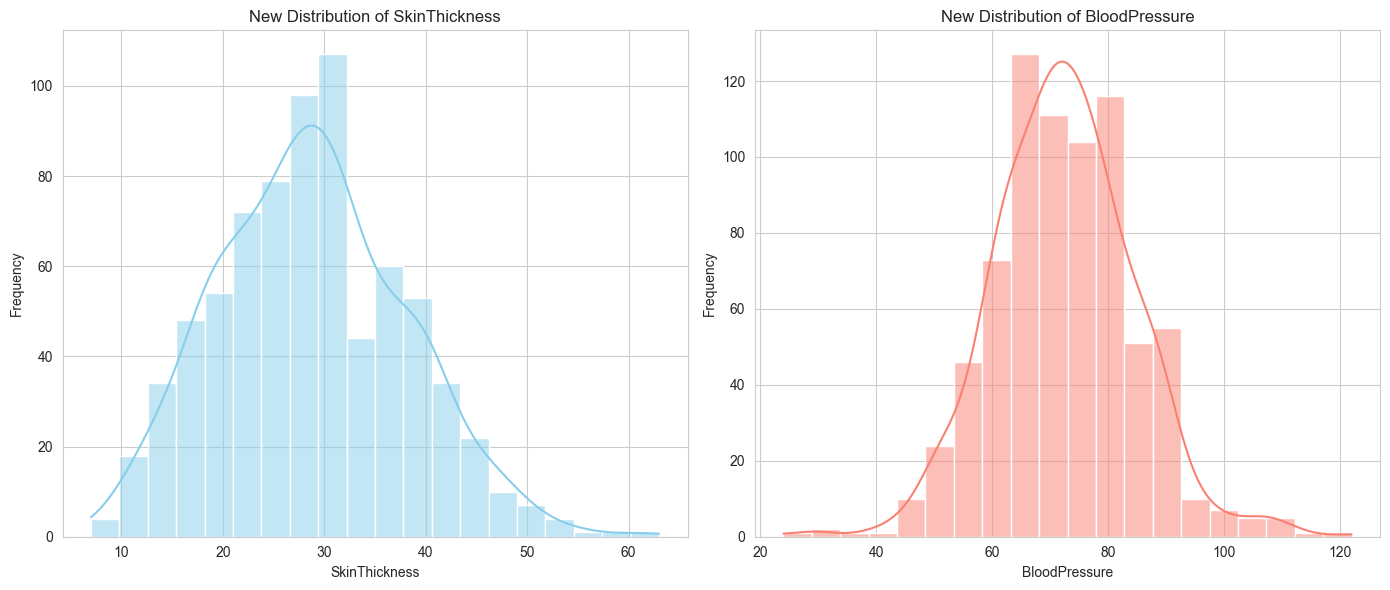

In [6]:
# Separate rows where SkinThickness is not zero
train_data = data[data['SkinThickness'] != 0]
X_train = train_data[['Glucose', 'BMI', 'Outcome', 'Age']]
y_train = train_data['SkinThickness']

# Separate rows where SkinThickness is zero (for prediction)
impute_data = data[data['SkinThickness'] == 0]
X_impute = impute_data[['Glucose', 'BMI', 'Outcome', 'Age']]

# Train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing values
predicted_skin_thickness = model.predict(X_impute)

# Explicitly set SkinThickness column to float
data['SkinThickness'] = data['SkinThickness'].astype(float)

# Update the DataFrame with imputed values
data.loc[data['SkinThickness'] == 0, 'SkinThickness'] = predicted_skin_thickness

print("Updated DataFrame with Regression Imputation of SkinThickness.")

# Separate rows where BloodPressure is not zero
train_data_bp = data[data['BloodPressure'] != 0]
X_train_bp = train_data_bp[['Age', 'BMI', 'Pregnancies', 'Glucose', 'Outcome']]
y_train_bp = train_data_bp['BloodPressure']

# Separate rows where BloodPressure is zero (for prediction)
impute_data_bp = data[data['BloodPressure'] == 0]
X_impute_bp = impute_data_bp[['Age', 'BMI', 'Pregnancies', 'Glucose', 'Outcome']]

# Train the regression model
model_bp = LinearRegression()
model_bp.fit(X_train_bp, y_train_bp)

# Predict missing values
predicted_blood_pressure = model_bp.predict(X_impute_bp)

# Explicitly set BloodPressure column to float
data['BloodPressure'] = data['BloodPressure'].astype(float)

# Update the DataFrame with imputed values
data.loc[data['BloodPressure'] == 0, 'BloodPressure'] = predicted_blood_pressure

print("Updated DataFrame with Regression Imputation of BloodPressure.")

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot distribution of SkinThickness
plt.subplot(1, 2, 1)
sns.histplot(data['SkinThickness'], kde=True, color='skyblue', bins=20)
plt.title('New Distribution of SkinThickness')
plt.xlabel('SkinThickness')
plt.ylabel('Frequency')

# Plot distribution of BloodPressure
plt.subplot(1, 2, 2)
sns.histplot(data['BloodPressure'], kde=True, color='salmon', bins=20)
plt.title('New Distribution of BloodPressure')
plt.xlabel('BloodPressure')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

These distributions seem reasonable and resemble the initial distribution; we will assume that the imputations have not introduced too much bias.

### Removing Outliers

We will remove outliers using the Inter-Quartile range (IQR) technique, to avoid negatively impacting the cluster analysis below and the performance of the ML algorithms. 

First, let's take a look at which features contain many outliers by looking at the boxplots. We will then remove these systematically (with the exception of the `Insulin` feature).

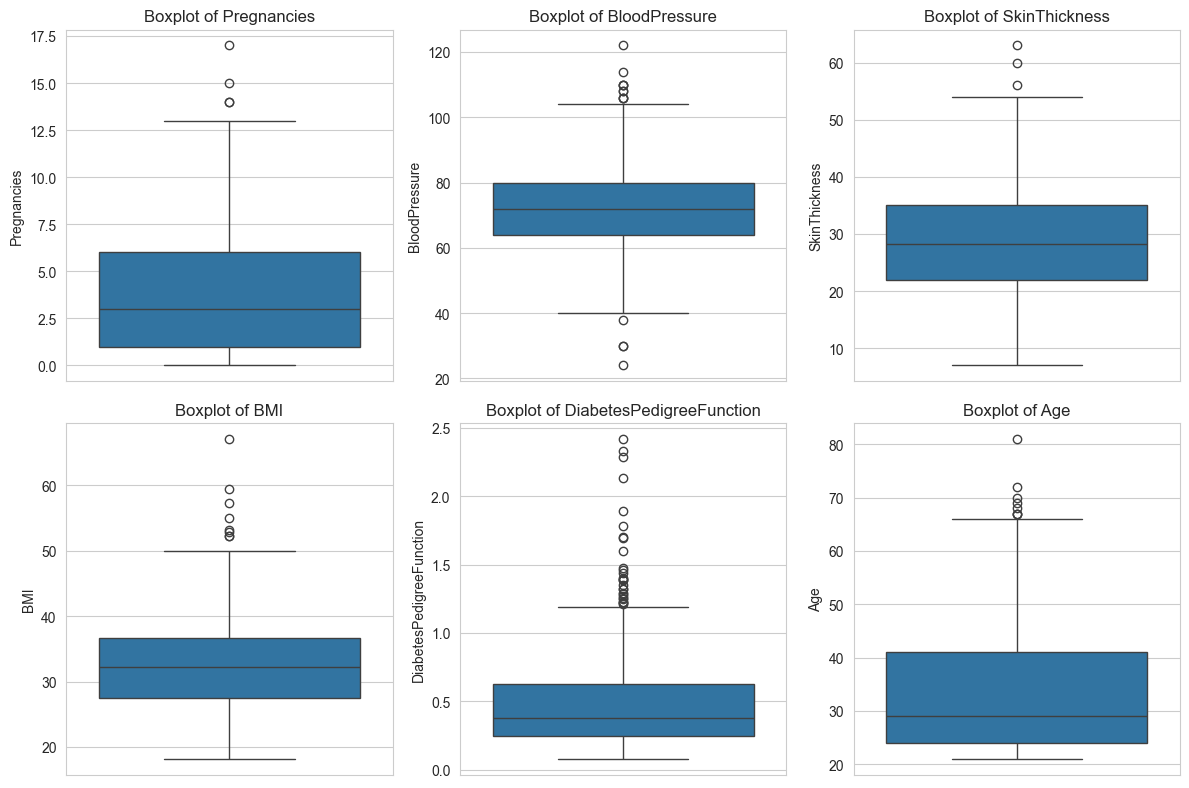

In [7]:
# Drop 'Outcome' and 'Insulin' columns
data_features = data.drop(columns=['Outcome', 'Insulin', 'Glucose'])

# Set the number of rows and columns for the grid
n_features = data_features.shape[1]
n_cols = 3  # Adjust the number of columns as needed
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
axes = axes.flatten()

# Plot each feature in its own subplot
for i, column in enumerate(data_features.columns):
    sns.boxplot(data=data_features[column], ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].tick_params(axis='x', rotation=90)

# Remove empty subplots if the number of features is not a multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [8]:
# Select columns to apply the IQR filter to (exclude 'Outcome' and 'Insulin')
columns_to_filter = data.columns.difference(['Outcome', 'Insulin', 'DiabetesPedigreeFunction'])

# Calculate IQR for each feature (Q3 - Q1)
Q1 = data[columns_to_filter].quantile(0.25)
Q3 = data[columns_to_filter].quantile(0.75)
IQR = Q3 - Q1

# Define bounds (lower and upper bounds based on IQR)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter rows where the values are within the IQR for each feature
for col in columns_to_filter:
    data = data[(data[col] >= lower_bound[col]) & (data[col] <= upper_bound[col])]

data = data[data['DiabetesPedigreeFunction'] <= 1.45]
    
print(f'Removed Outliers. {data.shape[0]} samples left.')

Removed Outliers. 708 samples left.


### 📏 Scaling the Data

Before diving into further exploratory data analysis (EDA) and clustering, it's important to **scale** the features in our dataset. Scaling ensures that all variables are on a comparable range, which is especially crucial when performing **distance-based techniques** like clustering or certain types of machine learning models. If features like glucose levels or BMI have much larger ranges than others (e.g., age or blood pressure), they will dominate the analysis, leading to **biased results**.

---

#### **Why Scale?**
1. **Fair Contribution**: When features have different ranges, higher-range features disproportionately influence distance calculations (as in clustering) or weight updates (as in gradient-based models). Scaling ensures that each feature contributes equally.
   
2. **Improved Model Performance**: Certain models, like **Logistic Regression, K-Means Clustering, and Support Vector Machines**, benefit significantly from scaled data. In these models, scaling can lead to faster convergence and better performance.

3. **Consistency Across Features**: Some features may have high variance while others may be more compact. By scaling, we normalize the spread of data, making patterns easier to detect.

---

#### **Visualizing the Need for Scaling** 📊

Here are the scatter plots of DiabetesPedigreeFunction vs Glucose, before and after scaling:

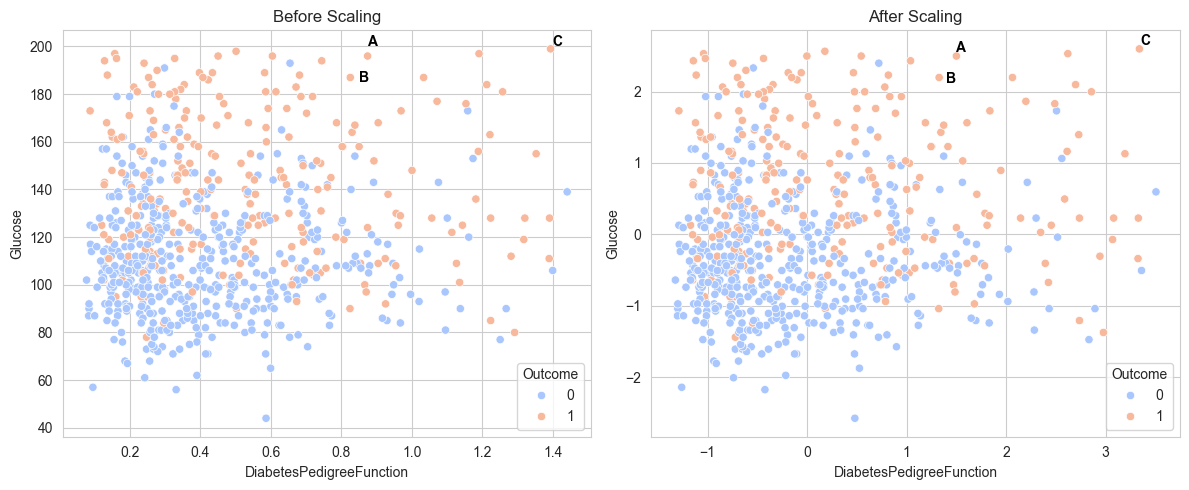

In [9]:
# Create a copy of the dataset for scaled data
df_scaled = data.copy()

# Apply scaling to relevant columns (BMI and DiabetesPedigreeFunction)
scaler = StandardScaler()
df_scaled[['Glucose', 'DiabetesPedigreeFunction']] = scaler.fit_transform(df_scaled[['Glucose', 'DiabetesPedigreeFunction']])

# Plotting before scaling
plt.figure(figsize=(12, 5))

# Define custom label positions and texts for before and after scaling
before_labels = {
    'C': (1.4, 200),  # (x, y) for Point A before scaling
    'A': (0.875, 200),  # (x, y) for Point B before scaling
    'B': (0.85, 185)   # (x, y) for Point C before scaling
}

after_labels = {
    'A': (1.5, 2.55),  # (x, y) for Point A after scaling
    'B': (1.4, 2.12),  # (x, y) for Point B after scaling
    'C': (3.35, 2.65)   # (x, y) for Point C after scaling
}

plt.subplot(1, 2, 1)
sns.scatterplot(data=data, x='DiabetesPedigreeFunction', y='Glucose', hue='Outcome', palette='coolwarm')
plt.title('Before Scaling')

# Add custom labels for specific points before scaling
for label, (x, y) in before_labels.items():
    plt.text(x, y, label, fontsize=10, color='black', weight='bold')


# Plotting after scaling
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_scaled, x='DiabetesPedigreeFunction', y='Glucose', hue='Outcome', palette='coolwarm')
plt.title('After Scaling')

# Add custom labels for specific points after scaling
for label, (x, y) in after_labels.items():
    plt.text(x, y, label, fontsize=10, color='black', weight='bold')


plt.tight_layout()
plt.show()

We can see that before scaling, despite A looking much closer to B than to C, the Euclidian distance between A and B is actually significantly way larger than the one between A and C. This will affect any distance based algorithms such as K-means clustering, and affect models sensitive to scale such as linear regression or support vector machine (SVM). 

Once we scale the data, the problem is no longer present. In our example, the Euclidian distance between A and B is much smaller than the one between A and C.

---

For this project, we'll use **StandardScaler** to scale the data, bringing each feature's mean to 0 and standard deviation to 1. This is typically the go-to approach for features following a roughly normal distribution.

In [10]:
#Scale all features using Standard Scaler
scaler = StandardScaler()

# Apply scaling to all columns except 'Age' and 'Pregnancies' (and 'Outcome')
columns_to_scale = data.columns.difference(['Outcome'])
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

import joblib
# Save the scaler
joblib.dump(scaler, 'models/scaler.pkl')
print("Scaler saved successfully.")

print("Standard scaler used on all features.")

Scaler saved successfully.
Standard scaler used on all features.


## 🔍 Exploratory Data Analysis (EDA)

Now that the data is cleaned, we will explore the data to see if we can discover patterns and find the most important factors for diabetes.

### A Quick First Look: Pairplot and Correlation Matrix

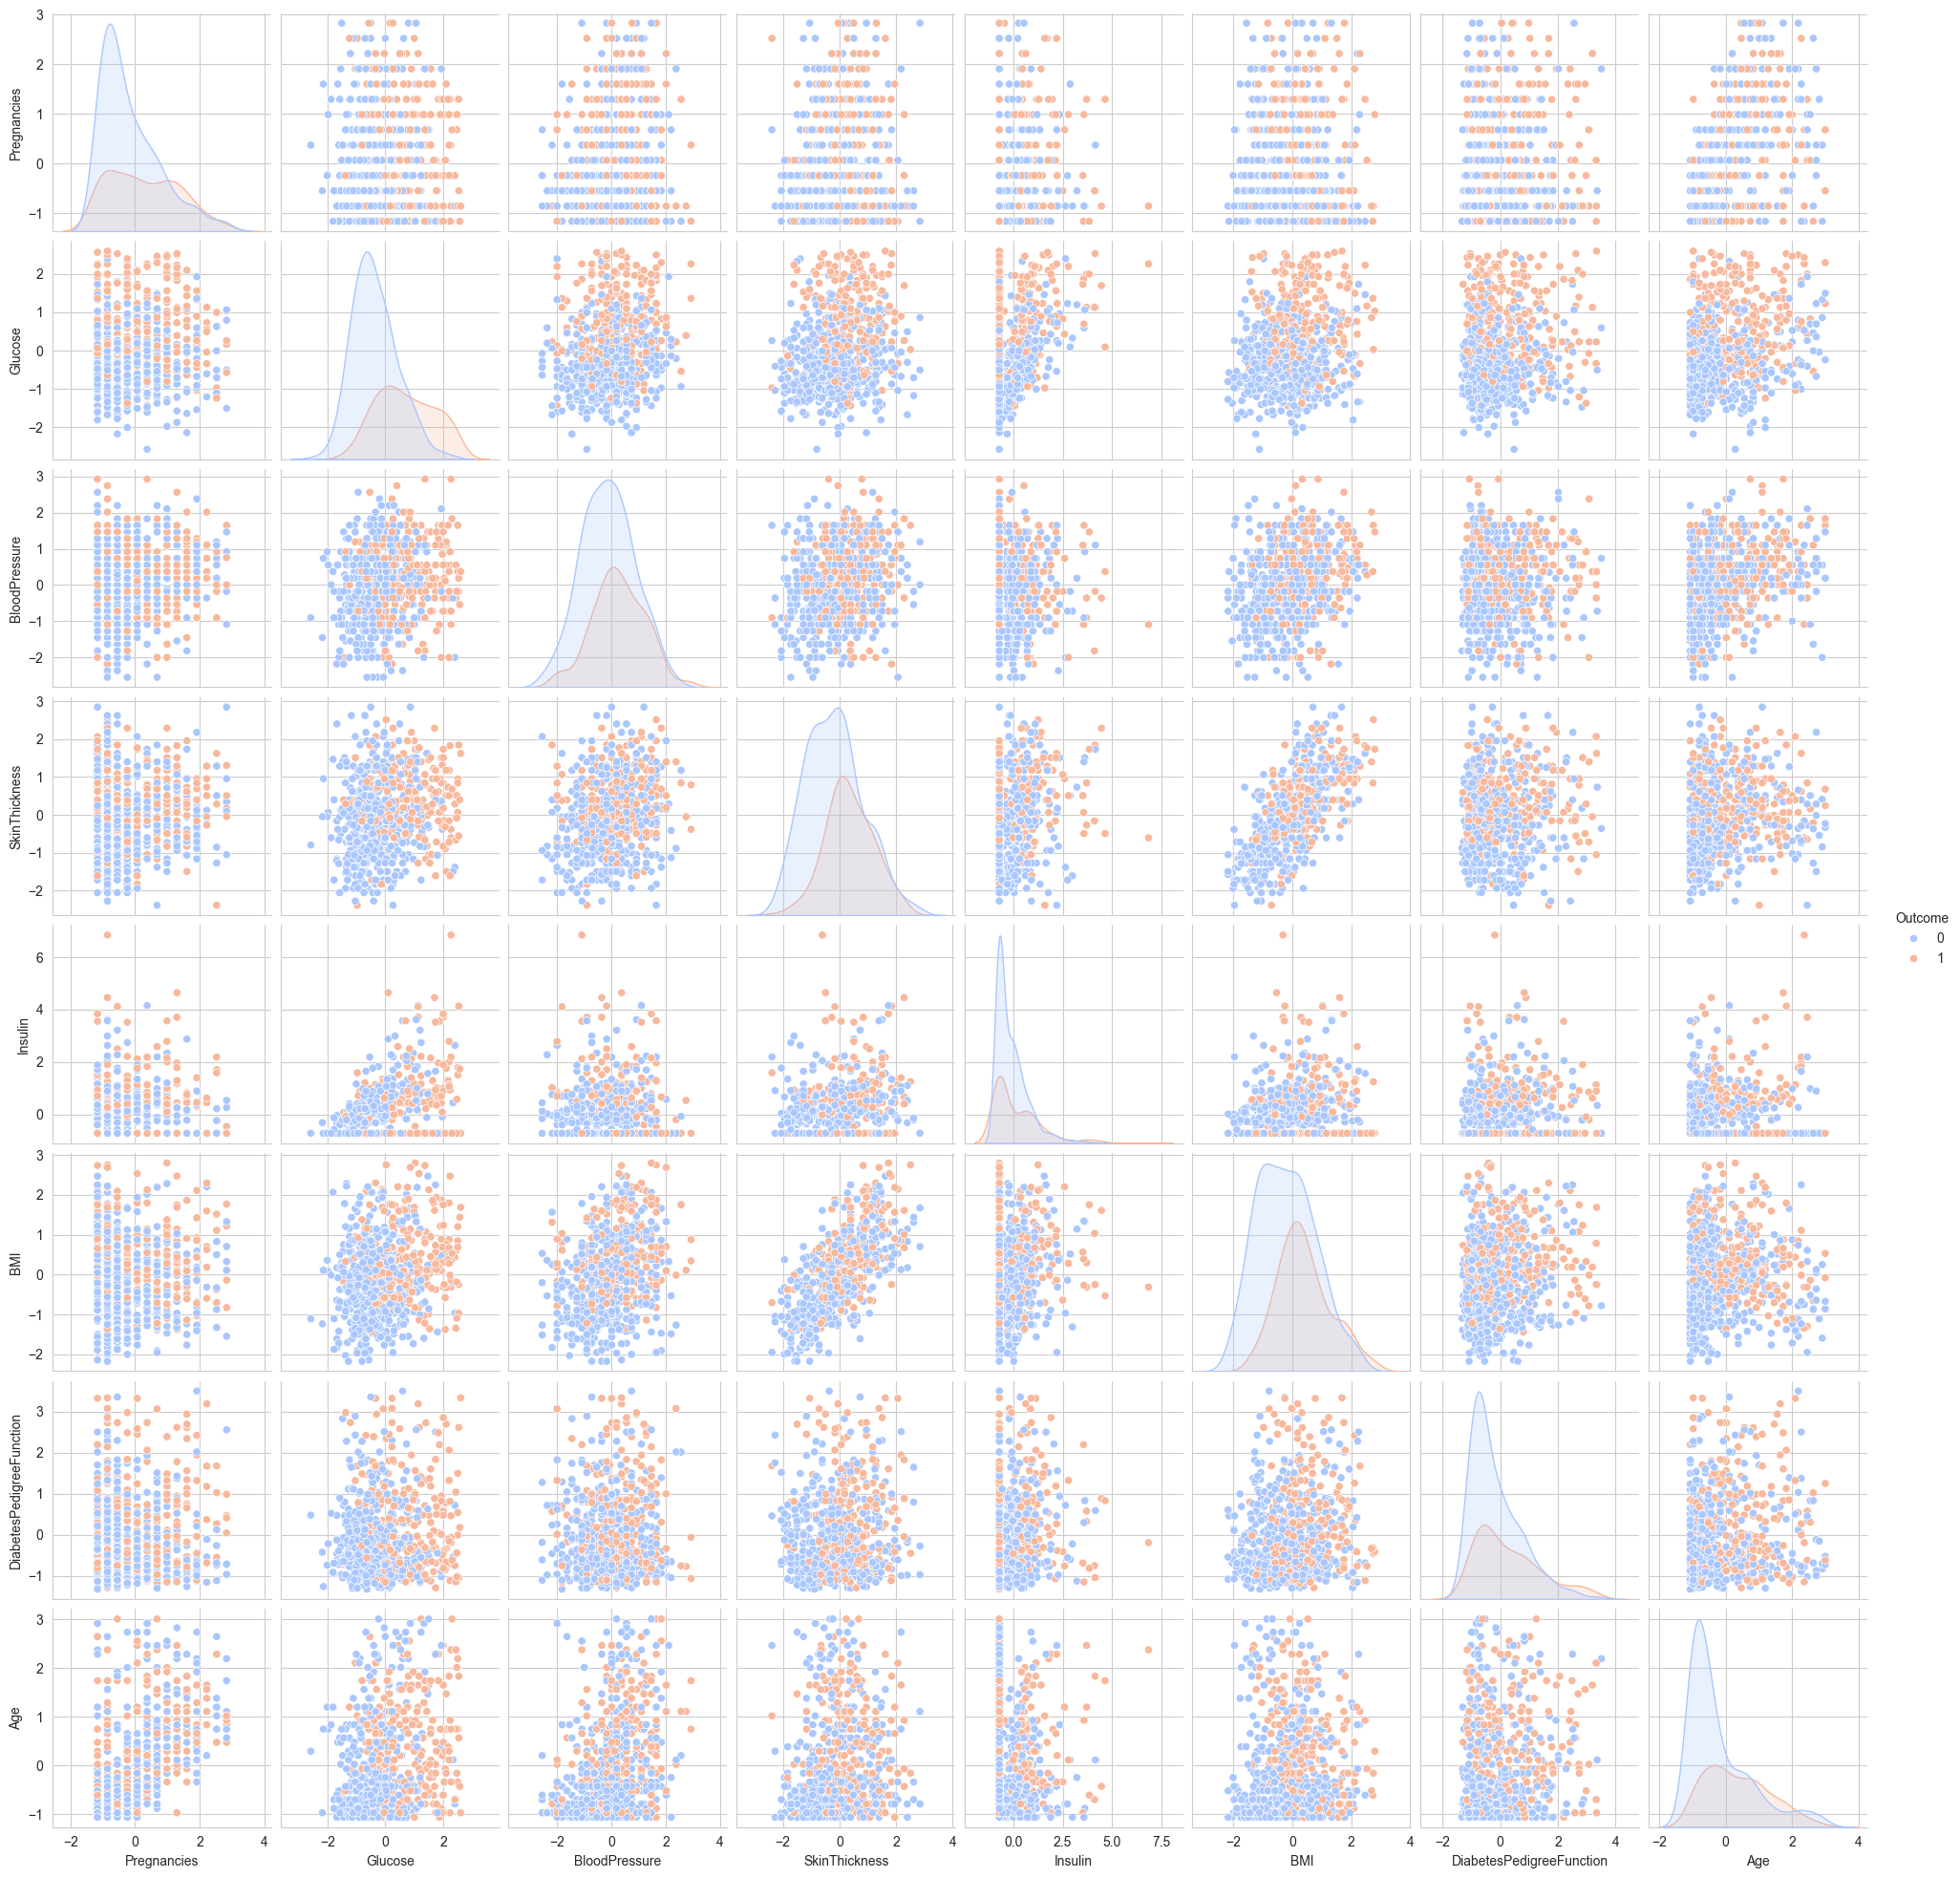

In [11]:
# Pairplot using seaborn
sns.pairplot(data, hue='Outcome', palette='coolwarm')
plt.show()

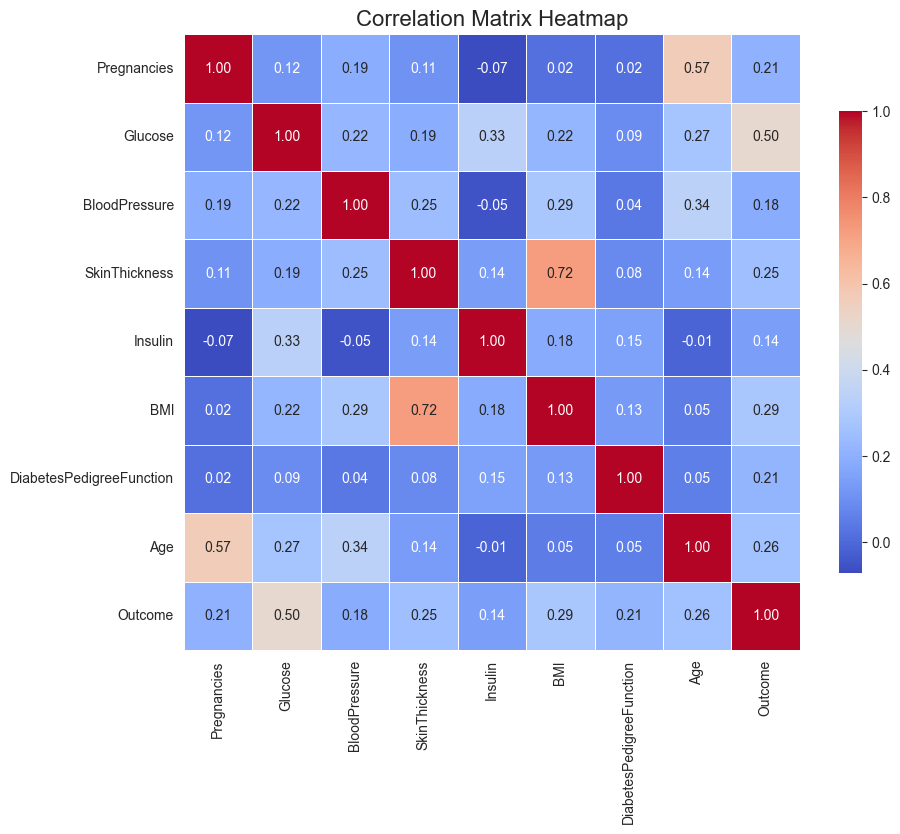

In [12]:
# Calculate the correlation matrix
corr_matrix = data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Generate a heatmap with 'coolwarm' color palette
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, cbar_kws={"shrink": 0.75}, square=True)

# Set the title for the heatmap
plt.title('Correlation Matrix Heatmap', fontsize=16)

# Show the plot
plt.show()

**Inference**:

- Based on both the pairplot and the correlation matrix, `Glucose` is clearly the most important factor for diabetes. 

- Other factors are also correlated to diabetes, but the correlations are not as strong. `BMI` nevertheless shows a correlation of 0.31 and is still likely an important factor.

- With no simple factor having very high correlations (>0.7), it is likely to be caused by the interaction of several factors at play. Different people can have diabetes for different reasons, which will be reflected in different ways in the data.
- Identifying diabetes based on one or two factors alone is therefore quite difficult. Apart from `Glucose`, a factor taken in isolation is not very informative. A more wholistic understanding of the person's medical information and history is required.<br>
<br>

- Given this, we will take the following approach: 
    - Can we try to identify various 'types' within the population? Can we identify clusters that group similar people together?
    - If so, we can then use these clusters to create positive and negative diabetes indicators, which can be used as features.
    - This could also, further downstream, increase interpretability of modelling results, which is a key factor for the doctors that would be using the results of the models.

In the following section, we will perform cluster analysis to identify relevant clusters. 

### Clustering Analysis

Before performing clustering analysis, we will separate the training and testing data to avoid data leakage, as we will try to find clusters that group similar outcomes together. Doing this on the entire dataset would be indirectly using information from the target of the test data to make predictions through the choice of engineered features/clusters, therefore causing data leakage.

K-means clustering was chosen as a first approach for clustering. Various values of k were tried. I settled on k=10, which offered a good tradeoff between cluster size and cluster usefulness. 

Selection of clusters:

- Ideally the size of the clusters is at least 5% of training population to be considered meaningful
- For negative indicators, which are easier to get, the threshold was set at any cluster with less than 8% of people having diabetes.
- For positive indicators, which are harder to get, the threshold was set at any cluster with more than 70% of people having diabetes.

Clusters for positive indicators are represented in red below. 
Clusters for negative indicators are represented in green below.

In [13]:
# We choose a 80-20 split, which is appropriate given the limited amount of data
train_data, test_data = train_test_split(data, test_size=0.175, random_state=42, stratify=data['Outcome'])
print('An 80-20 train-test stratified split was performed on data. The training set contains {} examples.'.format(len(train_data)))

An 80-20 train-test stratified split was performed on data. The training set contains 584 examples.


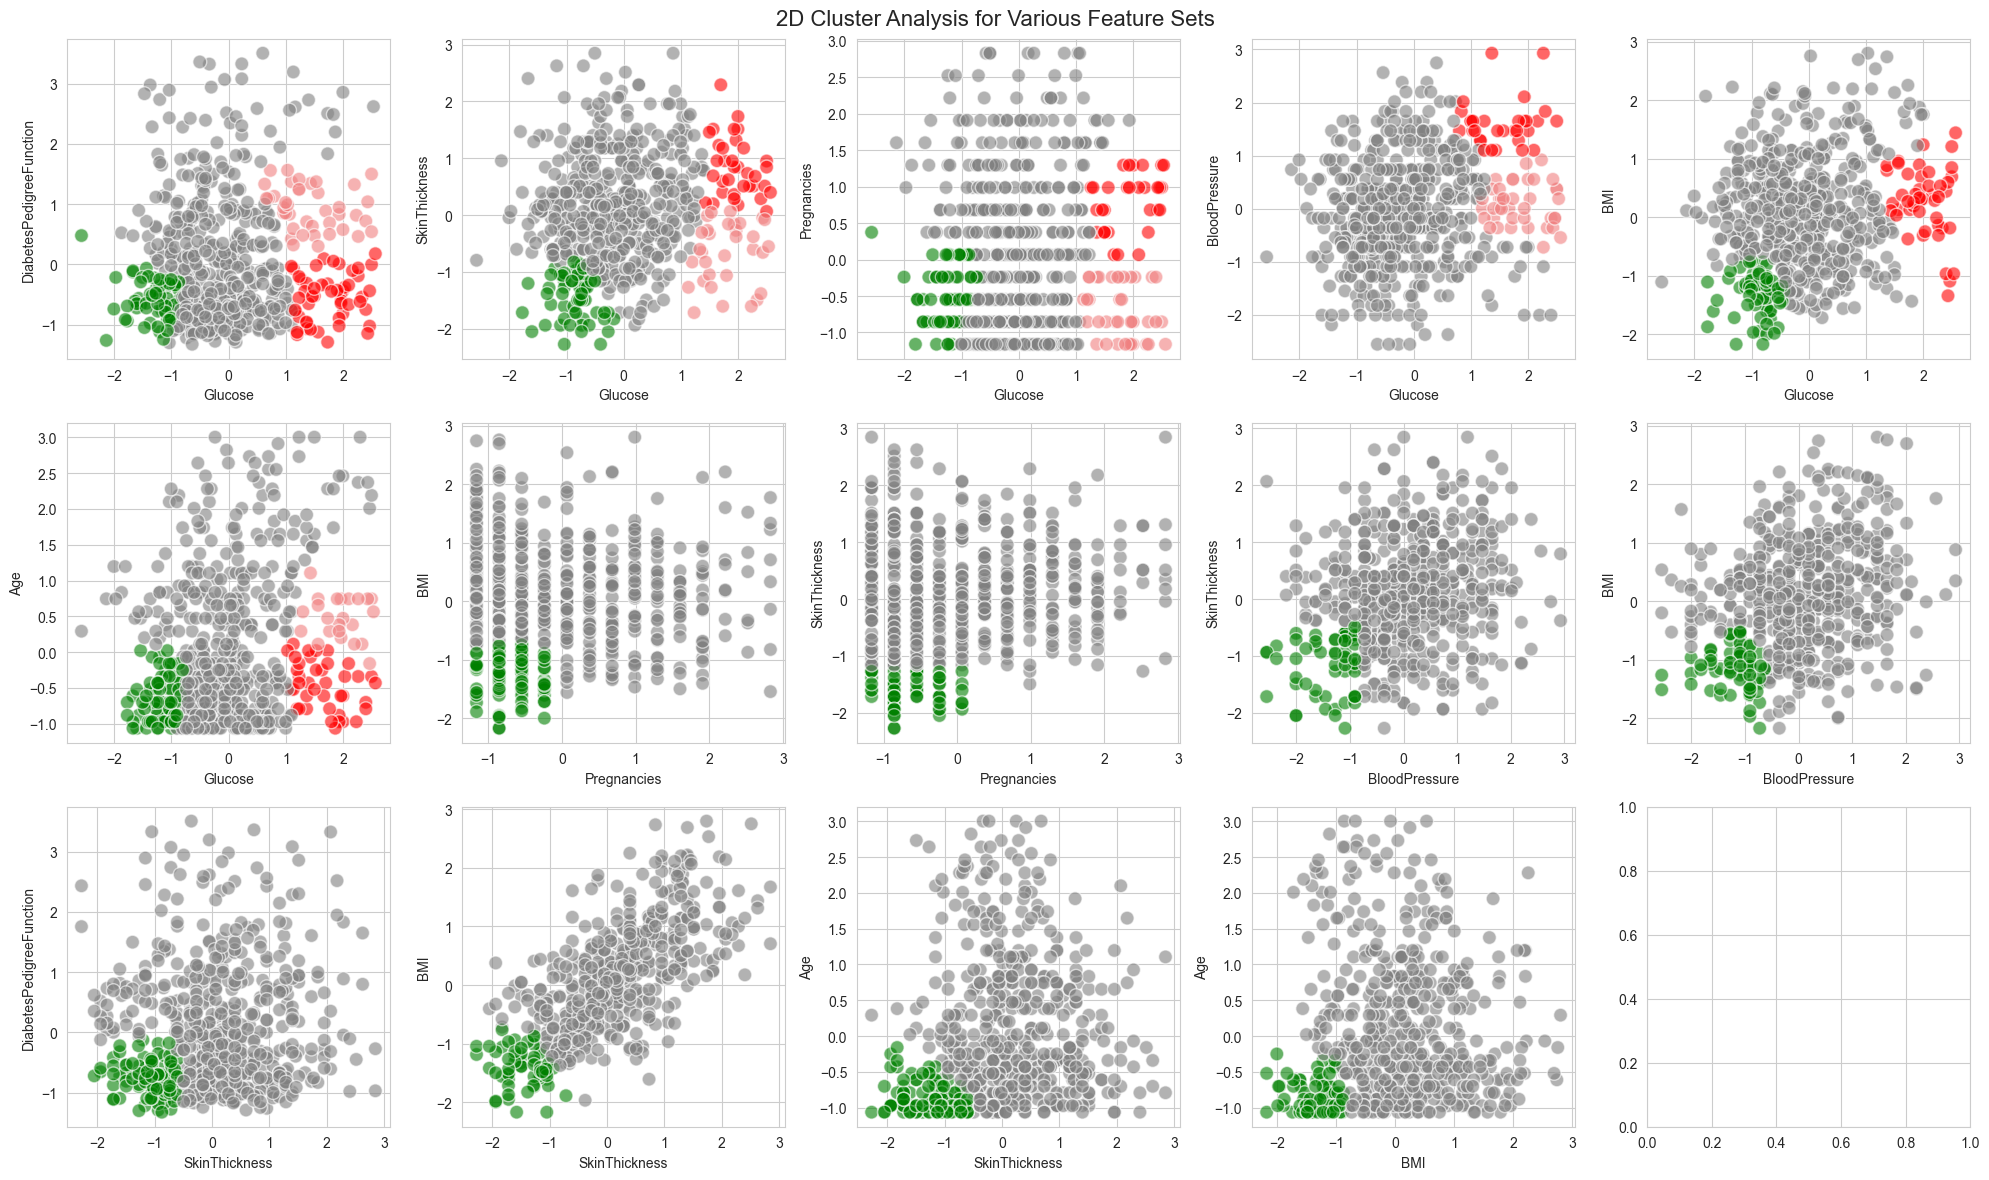

In [14]:
def analyze_clusters(data, feature_pair, ax, cluster_colors, n_clusters=10, random_state=42, display_clusters_tables=False):
    """
    Perform clustering analysis for a given pair of features and plot the results.

    Parameters:
    - data: The dataframe containing the features and target.
    - feature_pair: A list of two feature names to analyze.
    - ax: The matplotlib axis to plot the results.
    - cluster_colors: A dictionary mapping cluster labels to colors.
    - n_clusters: Number of clusters for K-means.
    - random_state: Random state for reproducibility.
    - display_clusters_tables: Whether to display cluster summaries.

    Returns:
    - centroids: The centroids of the clusters.
    - kmeans: the kmeans model trained on the feature pair
    """

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    data_copy = data.copy()
    data_copy['Cluster'] = kmeans.fit_predict(data[feature_pair])

    # Analyze cluster characteristics
    cluster_means = data_copy.groupby('Cluster')[feature_pair].mean()
    cluster_sizes = data_copy['Cluster'].value_counts().sort_index()
    centroids = cluster_means.copy()

    # Combine cluster means and sizes into a single DataFrame
    cluster_summary = cluster_means.copy()
    cluster_summary['Cluster Size'] = cluster_sizes

    # Calculate the average 'Outcome' for each cluster
    average_outcome_by_cluster = data_copy.groupby('Cluster')['Outcome'].mean()
    cluster_summary['Average Outcome'] = average_outcome_by_cluster

    # Display cluster summaries if needed
    if display_clusters_tables:
        print(f"Cluster Characteristics with Sizes and Average Outcome for features {feature_pair}:\n")
        display.display(cluster_summary)

    # Plot clusters in 2D
    colors = data_copy['Cluster'].map(cluster_colors).fillna('grey')
    ax.scatter(data_copy[feature_pair[0]], data_copy[feature_pair[1]], color=colors, alpha=0.6, edgecolor='w', s=100)
    ax.set_xlabel(feature_pair[0])
    ax.set_ylabel(feature_pair[1])

    return centroids, kmeans

# Define the feature sets and the colors for each cluster
feature_sets = [
    (['Glucose', 'DiabetesPedigreeFunction'], {2: 'red', 8: 'green', 6:'lightcoral'}),
    (['Glucose', 'SkinThickness'], {3: 'green', 9: 'red', 5:'lightcoral'}),
    (['Glucose', 'Pregnancies'], {8: 'red', 7: 'green', 2:'lightcoral'}),
    (['Glucose', 'BloodPressure'], {8: 'lightcoral', 1: 'red'}),
    (['Glucose', 'BMI'], {9: 'green', 1: 'red'}),
    (['Glucose', 'Age'], {6: 'green', 2: 'red', 7: 'lightcoral'}),
    (['Pregnancies', 'BMI'], {6: 'green'}),
    (['Pregnancies', 'SkinThickness'], {9: 'green'}),
    (['BloodPressure', 'SkinThickness'], {2: 'green'}),
    (['BloodPressure', 'BMI'], {7: 'green'}),
    (['SkinThickness', 'DiabetesPedigreeFunction'], {8:'green'}),
    (['SkinThickness', 'BMI'], {6: 'green'}),
    (['SkinThickness', 'Age'], {2: 'green'}),
    (['BMI', 'Age'], {3: 'green'}),
]

# Initialize the plot
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle('2D Cluster Analysis for Various Feature Sets', fontsize=16)

fitted_kmeans = {}
centroids = {}

# Perform clustering and plotting for each feature set
for i, (features, cluster_colors) in enumerate(feature_sets):
    row = i // 5
    col = i % 5
    ax = axes[row, col]

    # Analyze clusters and get scalers and centroids
    centroid, kmean = analyze_clusters(train_data, features, ax, cluster_colors, display_clusters_tables=False)

    # Save the scalers and centroids
    centroids[tuple(features)] = centroid
    fitted_kmeans[tuple(features)] = kmean

plt.tight_layout()
plt.show()

Inference:

- There is a common trend for all the pairs of features displayed above: 
    - clusters with low incidence (<8%) of diabetes occur at the bottom left of the graphs
    - clusters with high incidence (>70%) of diabetes occur at the top right of the graphs
- We will create a set of features to reflect presence or absence of these indicators
- We will also look at how the sum of indicators affect the chances of having diabetes.

In [15]:
def create_cluster_indicators(data, centroids, fitted_kmeans, feature_sets):
    """
    Create binary indicators for cluster memberships based on predefined cluster sets for each pair of features.
    Also creates global summary indicators for positive and negative clusters across all feature pairs.

    Parameters:
    - data: pandas DataFrame with the feature columns used for clustering.
    - centroids: dict mapping (feature1, feature2) tuples to cluster centroids.
    - fitted_kmeans: dict mapping (feature1, feature2) tuples to fitted KMeans instances.
    - feature_sets: list of tuples where each tuple contains:
        - A list of two features.
        - A list of negative cluster indices.
        - A list of positive cluster indices.

    Returns:
    - pandas DataFrame with the original data plus the new cluster indicator features and global summary indicators.
    """

    new_features = pd.DataFrame(index=data.index)
    
    pos_indicator_cols = []
    neg_indicator_cols = []
    
    for feature_pair, negative_clusters, positive_clusters in feature_sets:
        feature_pair_key = tuple(feature_pair)
        if feature_pair_key not in centroids or feature_pair_key not in fitted_kmeans:
            continue
        
        centroids_pair = centroids[feature_pair_key]
        kmeans = fitted_kmeans[feature_pair_key]
        
        # Extract and scale feature data
        feature_data = data[feature_pair]
        
        # Predict cluster labels using the fitted KMeans model
        cluster_labels = kmeans.predict(feature_data)
        
        # Create binary indicators for positive and negative clusters
        if positive_clusters:
            for cluster_idx in positive_clusters:
                col_name = f"Pos_Cluster_{'_'.join(feature_pair)}_{cluster_idx}"
                new_features[col_name] = (cluster_labels == cluster_idx).astype(int)
                pos_indicator_cols.append(col_name)
        
        if negative_clusters:
            for cluster_idx in negative_clusters:
                col_name = f"Neg_Cluster_{'_'.join(feature_pair)}_{cluster_idx}"
                new_features[col_name] = (cluster_labels == cluster_idx).astype(int)
                neg_indicator_cols.append(col_name)
    
    # Create global summary indicators
    if pos_indicator_cols:
        new_features["Sum_Pos_2D_Indicators"] = new_features[pos_indicator_cols].sum(axis=1)
    
    if neg_indicator_cols:
        new_features["Sum_Neg_2D_Indicators"] = new_features[neg_indicator_cols].sum(axis=1)
    
    return pd.concat([data, new_features], axis=1)

# define feature set for augmentation
feature_sets = [
    (['Glucose', 'DiabetesPedigreeFunction'], [8], [2, 6]),  # Feature pair, negative clusters, positive clusters
    (['Glucose', 'SkinThickness'], [3], [5, 9]),
    (['Glucose', 'Pregnancies'], [7], [2, 8]),
    (['Glucose', 'BloodPressure'], [], [1, 8]),
    (['Glucose', 'BMI'], [9], [1]),
    (['Glucose', 'Age'], [6], [2, 7]),
    (['Pregnancies', 'BMI'], [6], []),
    (['Pregnancies', 'SkinThickness'], [9], []),
    (['BloodPressure', 'SkinThickness'], [2], []),
    (['BloodPressure', 'BMI'], [7], []),
    (['SkinThickness', 'DiabetesPedigreeFunction'], [8], []),
    (['SkinThickness', 'BMI'], [6], []),
    (['SkinThickness', 'Age'], [2], []),
    (['BMI', 'Age'], [3], []),
]

# Get the new features
train_data_with_indicators = create_cluster_indicators(
    train_data, centroids, fitted_kmeans, feature_sets
)

test_data_with_indicators = create_cluster_indicators(
    test_data, centroids, fitted_kmeans, feature_sets
)

# Save centroids
joblib.dump(centroids, 'models/cluster_centroids.pkl')

# Save fitted KMeans models
joblib.dump(fitted_kmeans, 'models/fitted_kmeans.pkl')

print("Cluster centroids and fitted KMeans models saved successfully.")
print("2D Indicator features created for train and test data.")

# See results
# display.display(train_data[['Outcome', 'Sum_Pos_2D_Indicators', 'Sum_Neg_2D_Indicators']])

Cluster centroids and fitted KMeans models saved successfully.
2D Indicator features created for train and test data.


Let's take a look at the distribution of indicators by outcome:

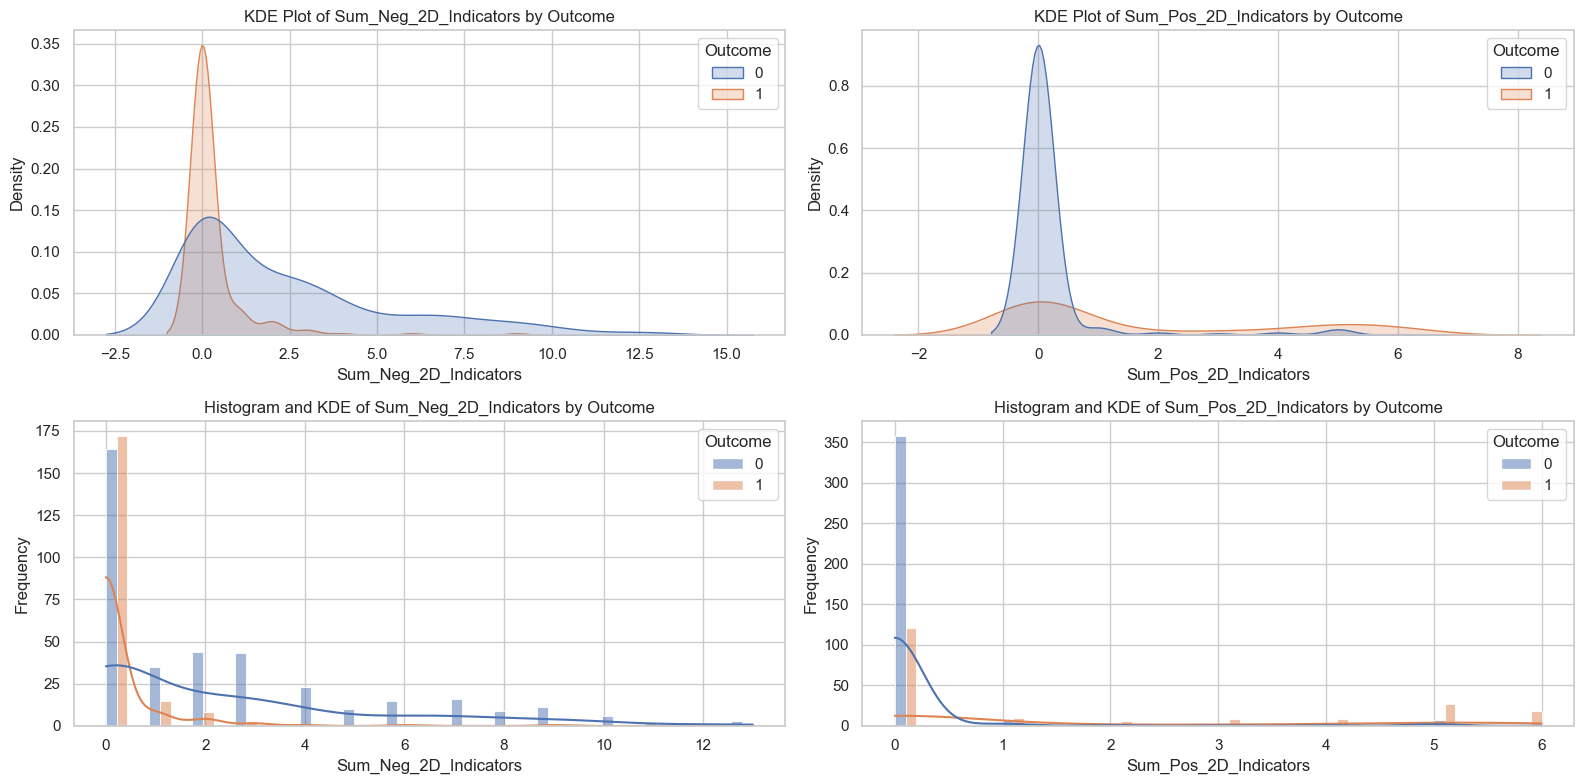

In [16]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(16,8), sharey=False)

# KDE plot for Sum_Neg_2D_Indicators
sns.kdeplot(
    data=train_data_with_indicators, 
    x='Sum_Neg_2D_Indicators', 
    hue='Outcome', 
    fill=True, 
    ax=axes[0, 0]
)
axes[0, 0].set_title('KDE Plot of Sum_Neg_2D_Indicators by Outcome')
axes[0, 0].set_xlabel('Sum_Neg_2D_Indicators')
axes[0, 0].set_ylabel('Density')

# KDE plot for Sum_Pos_2D_Indicators
sns.kdeplot(
    data=train_data_with_indicators, 
    x='Sum_Pos_2D_Indicators', 
    hue='Outcome', 
    fill=True, 
    ax=axes[0, 1]
)
axes[0, 1].set_title('KDE Plot of Sum_Pos_2D_Indicators by Outcome')
axes[0, 1].set_xlabel('Sum_Pos_2D_Indicators')
axes[0, 1].set_ylabel('Density')

# Histogram with KDE for Sum_Neg_2D_Indicators, side-by-side bars
sns.histplot(
    train_data_with_indicators, 
    x='Sum_Neg_2D_Indicators', 
    hue='Outcome', 
    kde=True, 
    bins=30, 
    ax=axes[1, 0], 
    multiple='dodge'
)
axes[1, 0].set_title('Histogram and KDE of Sum_Neg_2D_Indicators by Outcome')
axes[1, 0].set_xlabel('Sum_Neg_2D_Indicators')
axes[1, 0].set_ylabel('Frequency')

# Histogram with KDE for Sum_Pos_2D_Indicators, side-by-side bars
sns.histplot(
    train_data_with_indicators, 
    x='Sum_Pos_2D_Indicators', 
    hue='Outcome', 
    kde=True, 
    bins=30, 
    ax=axes[1, 1], 
    multiple='dodge'
)
axes[1, 1].set_title('Histogram and KDE of Sum_Pos_2D_Indicators by Outcome')
axes[1, 1].set_xlabel('Sum_Pos_2D_Indicators')
axes[1, 1].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

The analysis shows an interesting pattern regarding **negative and positive indicators**:

- **For negative indicators**:
  - Presence of negative indicators is a good sign of being diabetes-free. The large majority of people with diabetes have 0 of those.
  - Absence of negative indicators is not as strong of a signal: it seems to be more of a prerequisite to having diabetes rather than a determining factor. However, the distribution of outcomes in people with no indicators is flipped: more people have diabetes than not, which suggests that absence of negative indicators it is still an interesting feature

- **For positive indicators**:
  - Having positive diabetes indicators is a great sign of having diabetes.
  - The vast majority of people without diabetes have no positive indicators.
  - However, a large number of people with diabetes also have no positive indicators (over half of them). This suggests more complex factors are at play

---

Clearly, the **number of indicators** a person possesses can be a strong feature for determining whether they are at risk of diabetes. However, there is still a significant number of cases where the presence or absence of diabetes cannot be fully explained by these indicators alone. This suggests predicting diabetes is not always a straightforward task.

---

These observations raise an important question:

> **Why do people with no positive indicators have diabetes?**

Some follow-up questions worth investigating:
- Do they have traits we could identify?
- Are there more complex patterns that could explain why these people have diabetes?
- What differentiates them from people without diabetes?

---

The data suggests that **2D interactions** alone are insufficient to fully explain the presence of diabetes. A large number of subjects with diabetes have no positive 2D diabetes indicators.

To investigate this further, we can:
- Create new features.
- Look at feature interactions.
- Explore the possibility of finding **3D or 4D clusters**.

---

For this analysis, we will drop the subjects with **positive diabetes indicators**. The goal is to focus on subjects with diabetes but no positive 2D indicators, and see how they differ from people free from diabetes.

Created filtered dataframe, excluding subjects with positive diabetes indicators.
We also excluded subjects with 3 or more negative diabetes indicators. This filtered dataset contains 341 subjects.
Here are the correlation matrix and pairplot when excluding subjects with positive indicators:


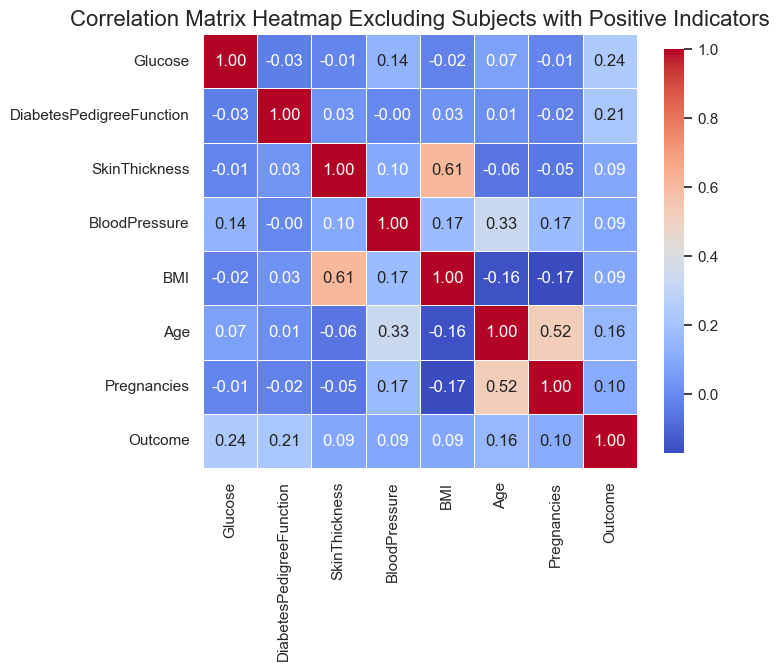

In [17]:
filtered_train_data = train_data_with_indicators[train_data_with_indicators['Sum_Pos_2D_Indicators'] < 1]
print('Created filtered dataframe, excluding subjects with positive diabetes indicators.')

filtered_train_data = filtered_train_data[filtered_train_data['Sum_Neg_2D_Indicators'] < 3]
print('We also excluded subjects with 3 or more negative diabetes indicators. This filtered dataset contains {} subjects.'.format(len(filtered_train_data)))

# let's see the new correlation matrix
print('Here are the correlation matrix and pairplot when excluding subjects with positive indicators:')

corr_matrix = filtered_train_data[['Glucose', 'DiabetesPedigreeFunction', 'SkinThickness', 'BloodPressure', 'BMI', 'Age', 'Pregnancies', 'Outcome']].corr()
# Set up the matplotlib figure
plt.figure(figsize=(7,7))

# Generate a heatmap with 'coolwarm' color palette
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, cbar_kws={"shrink": 0.75}, square=True)

# Set the title for the heatmap
plt.title('Correlation Matrix Heatmap Excluding Subjects with Positive Indicators', fontsize=16)

# Show the plot
plt.show()

As expected, once we exclude the subjects with positive indicators and those with **3 or more negative indicators**, determining which individuals have **Diabetes** becomes much more complex.

- Correlations with `Outcome` decrease significantly across the board and become **weaker**, with none exceeding 0.24. `BMI` for example is almost no longer correlated with the outcome anymore, with coefficients around 0.1 (down from close to 0.3).
- Interestingly, `DiabetesPedigreeFunction` seems to become more important. Its' correlation coefficient did not decrease, which could make sense intuitively; indeed, once we remove the subjects with indicators, which we could maybe see as 'lifestyle' factors, it seems reasonable that genetics start playing a larger role among those remaining. 

We will now take a look at feature interactions to see if we can discover any more complex patterns. 

---

#### Feature Interaction

Here is how we will proceed:

- We will systematically create interactions between any two of the original features.
- We will then try to perform cluster analysis using K-means like performed above.
- If no clusters are identified, we can also try to use the DBSCAN clustering approach, which handles non-spherical clusters and outliers better than K-Means.
- We can also try a hierarchical clustering approach, which can identify nested structures in the data quite well. 

---

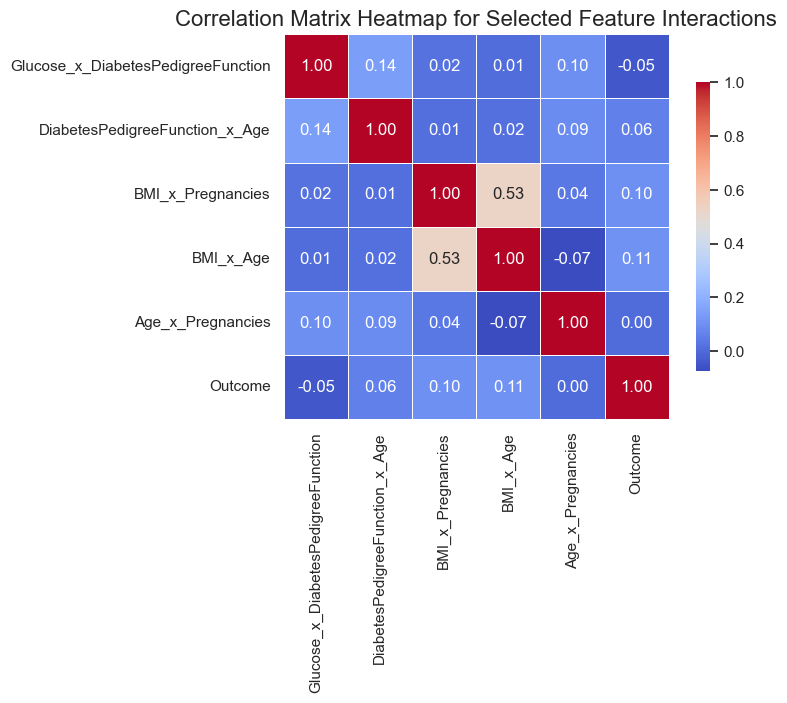

In [18]:
# Let's do some analysis of feature interactions
df = filtered_train_data.copy()

def create_interaction_features(df, features):
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            df[f'{features[i]}_x_{features[j]}'] = df[features[i]] * df[features[j]]
    return df

features = ['Glucose', 'DiabetesPedigreeFunction', 'SkinThickness', 'BloodPressure', 'BMI', 'Age', 'Pregnancies']

df = create_interaction_features(df, features)

# See effect on heatmap
# Calculate the correlation matrix
corr_matrix = df[
    [#'Glucose', 'DiabetesPedigreeFunction', 'SkinThickness', 'BloodPressure', 'BMI', 'Age', 'Pregnancies',  # these values can be found in the heatmap above
     
     #'Glucose_x_Age', 'Glucose_x_Pregnancies', 'Glucose_x_BloodPressure', 
     'Glucose_x_DiabetesPedigreeFunction', 
     #'Glucose_x_SkinThickness', 'Glucose_x_BMI', 
     
     #'DiabetesPedigreeFunction_x_SkinThickness', 'DiabetesPedigreeFunction_x_BloodPressure', 'DiabetesPedigreeFunction_x_BMI',
     'DiabetesPedigreeFunction_x_Age', #'DiabetesPedigreeFunction_x_Pregnancies',  
     
     #'SkinThickness_x_BloodPressure', 'SkinThickness_x_BMI', 'SkinThickness_x_Pregnancies', 
     #'SkinThickness_x_Age', 
     
     #'BloodPressure_x_BMI', 'BloodPressure_x_Age', 'BloodPressure_x_Pregnancies',  
     
     'BMI_x_Pregnancies', 'BMI_x_Age',
     
     'Age_x_Pregnancies', 
        
     'Outcome', 
    ]
].corr()


# Plot heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, cbar_kws={"shrink": 0.75}, square=True)

# Set the title for the heatmap
plt.title('Correlation Matrix Heatmap for Selected Feature Interactions', fontsize=16)

# Show the plot
plt.show()

Once again, even with feature interaction terms, no strong linear signal is observed, suggesting non-linear patters.

---

We will now try to use K-Means clustering to find interesting clusters in the population.

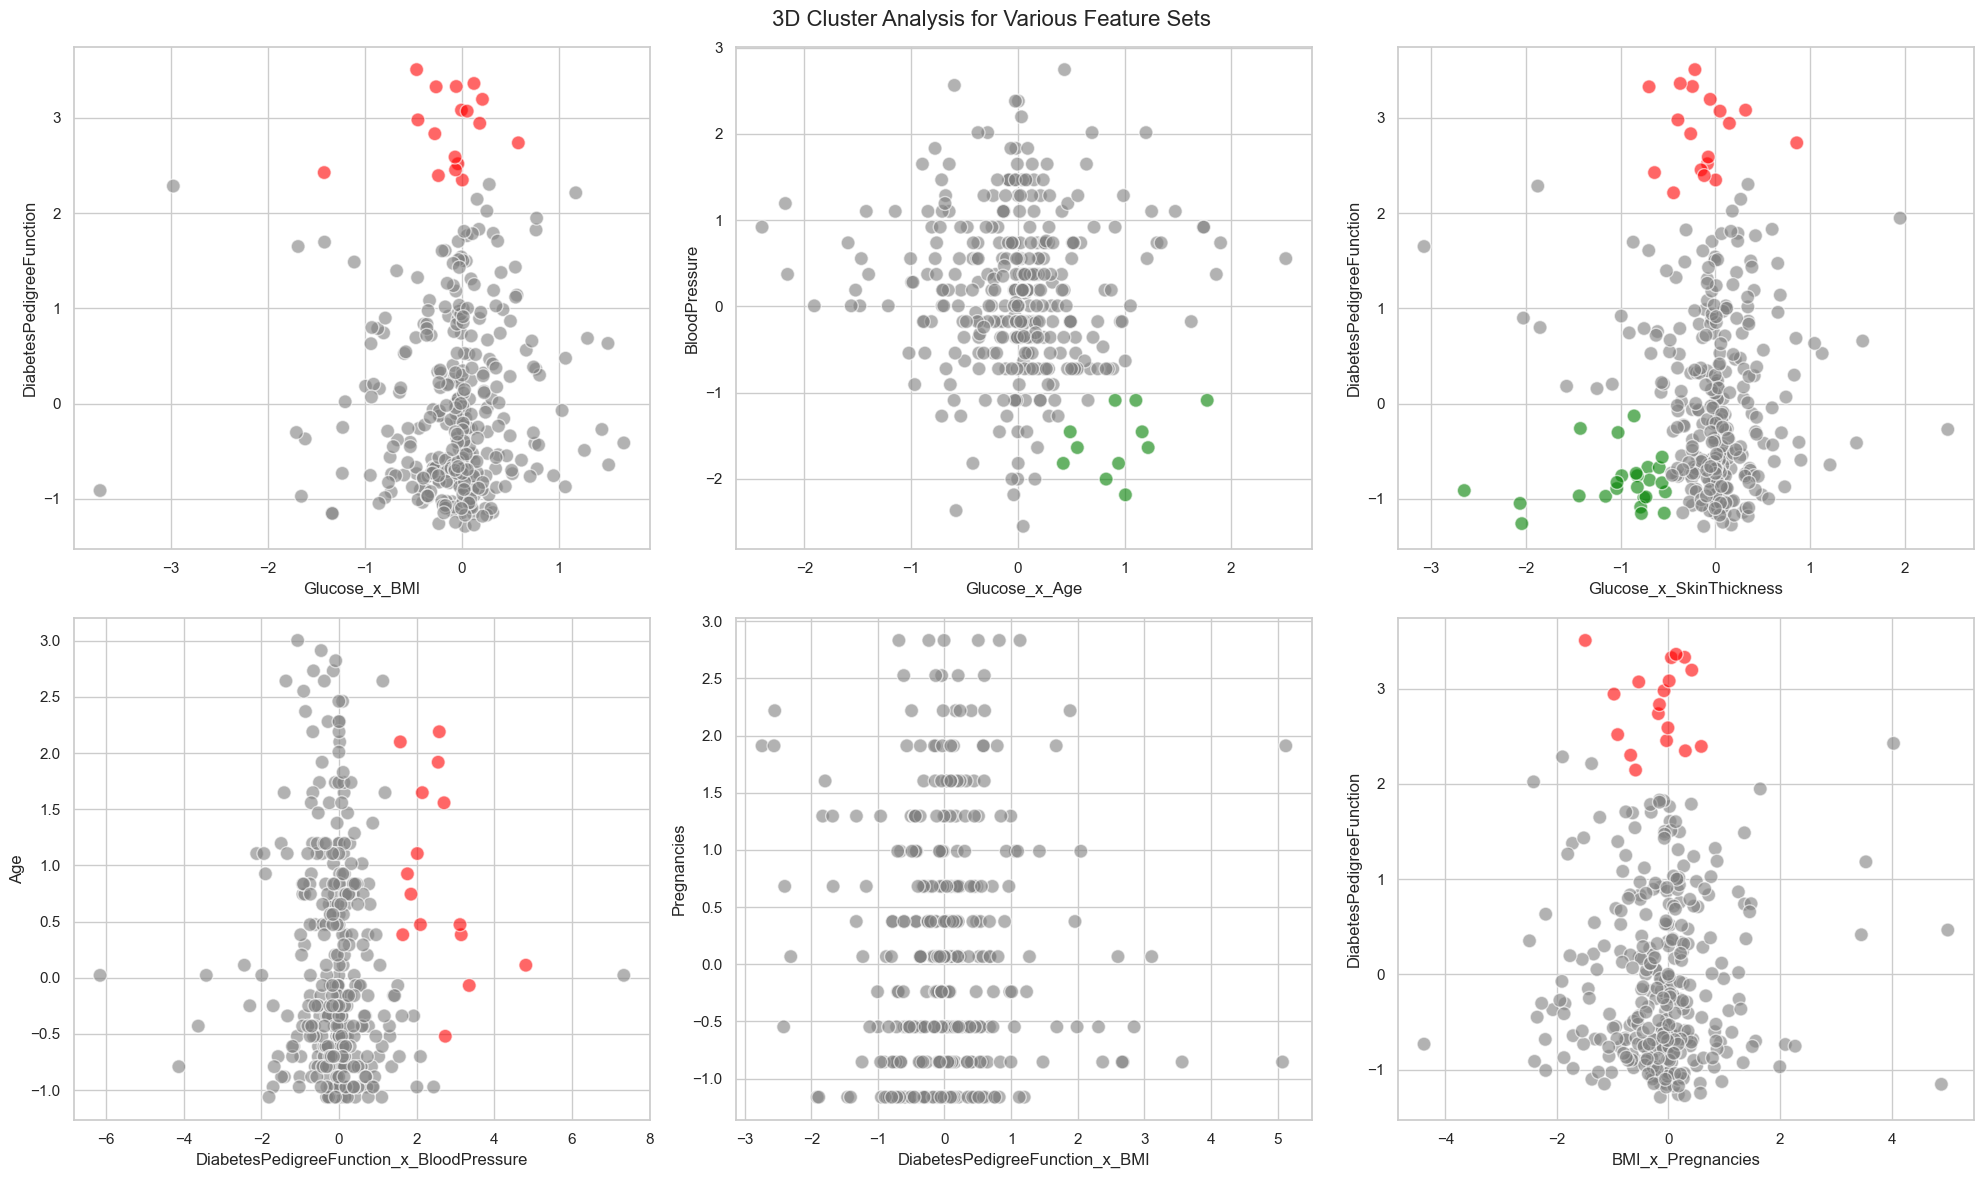

In [19]:
# Define the feature sets and the colors for each cluster
feature_sets = [    
    (['Glucose_x_BMI', 'DiabetesPedigreeFunction'], {6:'red'}), 
    #(['Glucose_x_BMI', 'SkinThickness'], {}),
    #(['Glucose_x_BMI', 'Pregnancies'], {}), 
    #(['Glucose_x_BMI', 'BloodPressure'], {}), 
    #(['Glucose_x_BMI', 'Age'], {}),
    
    #(['Glucose_x_Age', 'DiabetesPedigreeFunction'], {}),
    #(['Glucose_x_Age', 'SkinThickness'], {}), 
    #(['Glucose_x_Age', 'Pregnancies'], {}), 
    (['Glucose_x_Age', 'BloodPressure'], {7:'green'}), 
    #(['Glucose_x_Age', 'BMI'], {}),
    
    #(['Glucose_x_Pregnancies', 'DiabetesPedigreeFunction'], {}),
    #(['Glucose_x_Pregnancies', 'SkinThickness'], {}),
    #(['Glucose_x_Pregnancies', 'Age'], {}),
    #(['Glucose_x_Pregnancies', 'BloodPressure'], {}),
    #(['Glucose_x_Pregnancies', 'BMI'], {}),
    
    #(['Glucose_x_BloodPressure', 'DiabetesPedigreeFunction'], {}),
    #(['Glucose_x_BloodPressure', 'SkinThickness'], {}),
    #(['Glucose_x_BloodPressure', 'Age'], {2:'red'}),
    #(['Glucose_x_BloodPressure', 'Pregnancies'], {}),
    #(['Glucose_x_BloodPressure', 'BMI'], {}),
    
    (['Glucose_x_SkinThickness', 'DiabetesPedigreeFunction'], {3:'red', 4:'green'}),
    #(['Glucose_x_SkinThickness', 'BMI'], {}),  
    #(['Glucose_x_SkinThickness', 'Pregnancies'], {}),  
    #(['Glucose_x_SkinThickness', 'BloodPressure'], {}),  
    #(['Glucose_x_SkinThickness', 'Age'], {}),  
    
    #(['Glucose_x_DiabetesPedigreeFunction', 'BMI'], {}),
    #(['Glucose_x_DiabetesPedigreeFunction', 'SkinThickness'], {}),
    #(['Glucose_x_DiabetesPedigreeFunction', 'Pregnancies'], {}),
    #(['Glucose_x_DiabetesPedigreeFunction', 'BloodPressure'], {}),
    #(['Glucose_x_DiabetesPedigreeFunction', 'Age'], {}),
    
    #(['DiabetesPedigreeFunction_x_SkinThickness', 'Glucose'], {}),
    #(['DiabetesPedigreeFunction_x_SkinThickness', 'BMI'], {}),  
    #(['DiabetesPedigreeFunction_x_SkinThickness', 'Pregnancies'], {}),
    #(['DiabetesPedigreeFunction_x_SkinThickness', 'BloodPressure'], {}),
    #(['DiabetesPedigreeFunction_x_SkinThickness', 'Age'], {}),
    
    #(['DiabetesPedigreeFunction_x_BloodPressure', 'Glucose'], {}),
    #(['DiabetesPedigreeFunction_x_BloodPressure', 'BMI'], {}),
    #(['DiabetesPedigreeFunction_x_BloodPressure', 'Pregnancies'], {}),
    #(['DiabetesPedigreeFunction_x_BloodPressure', 'SkinThickness'], {}),
    (['DiabetesPedigreeFunction_x_BloodPressure', 'Age'], {5:'red'}),
    
    #(['DiabetesPedigreeFunction_x_BMI', 'Glucose'], {}),
    #(['DiabetesPedigreeFunction_x_BMI', 'BloodPressure'], {}),
    (['DiabetesPedigreeFunction_x_BMI', 'Pregnancies'], {}),
    #(['DiabetesPedigreeFunction_x_BMI', 'SkinThickness'], {}),
    #(['DiabetesPedigreeFunction_x_BMI', 'Age'], {}),
    
    #(['DiabetesPedigreeFunction_x_Age', 'Glucose'], {}),
    #(['DiabetesPedigreeFunction_x_Age', 'BloodPressure'], {}),
    #(['DiabetesPedigreeFunction_x_Age', 'Pregnancies'], {}),
    #(['DiabetesPedigreeFunction_x_Age', 'SkinThickness'], {}),
    #(['DiabetesPedigreeFunction_x_Age', 'BMI'], {}),
    
    #(['DiabetesPedigreeFunction_x_Pregnancies', 'Glucose'], {}),
    #(['DiabetesPedigreeFunction_x_Pregnancies', 'BloodPressure'], {}),
    #(['DiabetesPedigreeFunction_x_Pregnancies', 'Age'], {}),
    #(['DiabetesPedigreeFunction_x_Pregnancies', 'SkinThickness'], {}),
    #(['DiabetesPedigreeFunction_x_Pregnancies', 'BMI'], {}),
    
    #(['SkinThickness_x_Age', 'Glucose'], {}),
    #(['SkinThickness_x_Age', 'BloodPressure'], {}),
    #(['SkinThickness_x_Age', 'DiabetesPedigreeFunction'], {}),
    #(['SkinThickness_x_Age', 'Pregnancies'], {}),
    #(['SkinThickness_x_Age', 'BMI'], {}),
    
    #(['SkinThickness_x_BMI', 'Glucose'], {}),
    #(['SkinThickness_x_BMI', 'BloodPressure'], {}),
    #(['SkinThickness_x_BMI', 'DiabetesPedigreeFunction'], {}),
    #(['SkinThickness_x_BMI', 'Pregnancies'], {}),
    #(['SkinThickness_x_BMI', 'Age'], {}),
    
    #(['SkinThickness_x_Pregnancies', 'Glucose'], {}),
    #(['SkinThickness_x_Pregnancies', 'BloodPressure'], {}),
    #(['SkinThickness_x_Pregnancies', 'DiabetesPedigreeFunction'], {}),
    #(['SkinThickness_x_Pregnancies', 'Age'], {}),
    #(['SkinThickness_x_Pregnancies', 'BMI'], {}),
    
    #(['BloodPressure_x_BMI', 'Glucose'], {}),
    #(['BloodPressure_x_BMI', 'SkinThickness'], {}),
    #(['BloodPressure_x_BMI', 'DiabetesPedigreeFunction'], {}),
    #(['BloodPressure_x_BMI', 'Age'], {}),
    #(['BloodPressure_x_BMI', 'Pregnancies'], {}),
    
    #(['BloodPressure_x_Age', 'Glucose'], {}),
    #(['BloodPressure_x_Age', 'SkinThickness'], {}),
    #(['BloodPressure_x_Age', 'DiabetesPedigreeFunction'], {}),
    #(['BloodPressure_x_Age', 'BMI'], {}),
    #(['BloodPressure_x_Age', 'Pregnancies'], {}),
    
    #(['BloodPressure_x_Pregnancies', 'Glucose'], {}),
    #(['BloodPressure_x_Pregnancies', 'SkinThickness'], {}),
    #(['BloodPressure_x_Pregnancies', 'DiabetesPedigreeFunction'], {}),
    #(['BloodPressure_x_Pregnancies', 'BMI'], {}),
    #(['BloodPressure_x_Pregnancies', 'Age'], {}),
        
    #(['BMI_x_Age', 'Glucose'], {}),
    #(['BMI_x_Age', 'BloodPressure'], {}),
    #(['BMI_x_Age', 'DiabetesPedigreeFunction'], {}),
    #(['BMI_x_Age', 'Pregnancies'], {}),
    #(['BMI_x_Age', 'SkinThickness'], {}),
    
    #(['BMI_x_Pregnancies', 'Glucose'], {}),
    #(['BMI_x_Pregnancies', 'BloodPressure'], {}),
    (['BMI_x_Pregnancies', 'DiabetesPedigreeFunction'], {8:'red'}),
    #(['BMI_x_Pregnancies', 'Age'], {}),
    #(['BMI_x_Pregnancies', 'SkinThickness'], {}),
]

# Initialize the plot
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('3D Cluster Analysis for Various Feature Sets', fontsize=16)

fitted_kmeans_filtered = {}
centroids_filtered = {}

# Perform clustering and plotting for each feature set
for i, (features, cluster_colors) in enumerate(feature_sets):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    # Analyze clusters and get scalers and centroids
    centroid, kmean = analyze_clusters(df, features, ax, cluster_colors, n_clusters=9, display_clusters_tables=False)

    # Save the kmeans models and centroids
    centroids_filtered[tuple(features)] = centroid
    fitted_kmeans_filtered[tuple(features)] = kmean

plt.tight_layout()
plt.show()

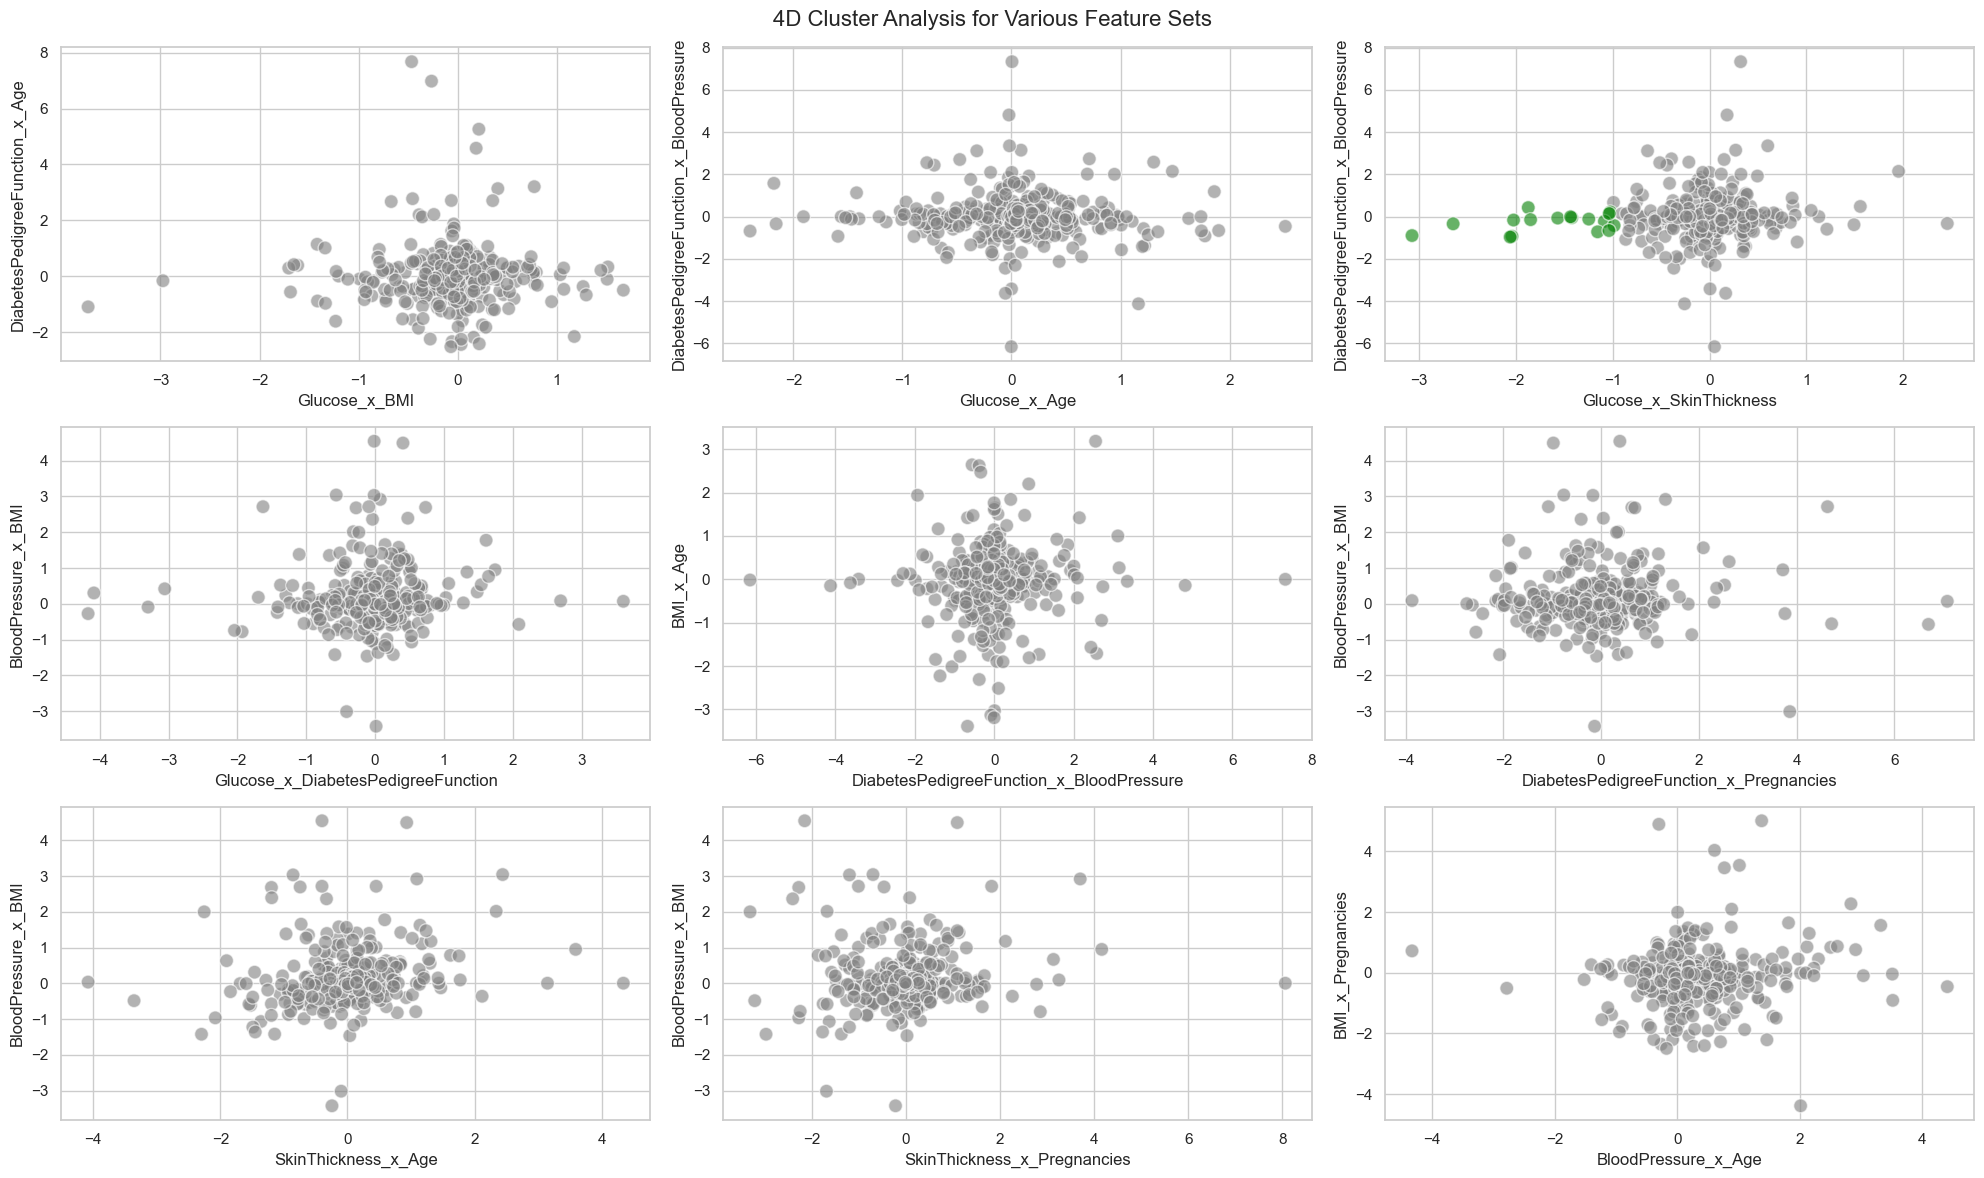

In [20]:
# Define the feature sets and the colors for each cluster
feature_sets = [    
    #(['Glucose_x_BMI', 'DiabetesPedigreeFunction_x_SkinThickness'], {}),
    #(['Glucose_x_BMI', 'DiabetesPedigreeFunction_x_BloodPressure'], {}),
    (['Glucose_x_BMI', 'DiabetesPedigreeFunction_x_Age'], {}),
    #(['Glucose_x_BMI', 'DiabetesPedigreeFunction_x_Pregnancies'], {}),
    #(['Glucose_x_BMI', 'SkinThickness_x_Pregnancies'], {}),
    #(['Glucose_x_BMI', 'SkinThickness_x_Age'], {}),
    #(['Glucose_x_BMI', 'BloodPressure_x_Age'], {}),
    #(['Glucose_x_BMI', 'BloodPressure_x_Pregnancies'], {}),
    
    #(['Glucose_x_Age', 'DiabetesPedigreeFunction_x_SkinThickness'], {}),
    (['Glucose_x_Age', 'DiabetesPedigreeFunction_x_BloodPressure'], {}),
    #(['Glucose_x_Age', 'DiabetesPedigreeFunction_x_BMI'], {}),
    #(['Glucose_x_Age', 'DiabetesPedigreeFunction_x_Pregnancies'], {}),
    #(['Glucose_x_Age', 'SkinThickness_x_Pregnancies'], {}),
    #(['Glucose_x_Age', 'SkinThickness_x_BMI'], {}),
    #(['Glucose_x_Age', 'BloodPressure_x_BMI'], {}),
    #(['Glucose_x_Age', 'BloodPressure_x_Pregnancies'], {}),
    
    #(['Glucose_x_Pregnancies', 'DiabetesPedigreeFunction_x_SkinThickness'], {}),
    #(['Glucose_x_Pregnancies', 'DiabetesPedigreeFunction_x_BloodPressure'], {}),
    #(['Glucose_x_Pregnancies', 'DiabetesPedigreeFunction_x_BMI'], {}),
    #(['Glucose_x_Pregnancies', 'DiabetesPedigreeFunction_x_Age'], {}),
    #(['Glucose_x_Pregnancies', 'SkinThickness_x_Age'], {}),
    #(['Glucose_x_Pregnancies', 'SkinThickness_x_BMI'], {}),
    #(['Glucose_x_Pregnancies', 'BloodPressure_x_BMI'], {}),
    #(['Glucose_x_Pregnancies', 'BloodPressure_x_Age'], {}),
    
    #(['Glucose_x_BloodPressure', 'DiabetesPedigreeFunction_x_SkinThickness'], {}),
    #(['Glucose_x_BloodPressure', 'DiabetesPedigreeFunction_x_Pregnancies'], {}),
    #(['Glucose_x_BloodPressure', 'DiabetesPedigreeFunction_x_BMI'], {}),
    #(['Glucose_x_BloodPressure', 'DiabetesPedigreeFunction_x_Age'], {}),
    #(['Glucose_x_BloodPressure', 'SkinThickness_x_Age'], {}),
    #(['Glucose_x_BloodPressure', 'SkinThickness_x_BMI'], {}),
    #(['Glucose_x_BloodPressure', 'BMI_x_Pregnancies'], {}),
    #(['Glucose_x_BloodPressure', 'Age_x_Pregnancies'], {}),
    
    (['Glucose_x_SkinThickness', 'DiabetesPedigreeFunction_x_BloodPressure'], {3:'green'}),
    #(['Glucose_x_SkinThickness', 'DiabetesPedigreeFunction_x_Pregnancies'], {}),
    #(['Glucose_x_SkinThickness', 'DiabetesPedigreeFunction_x_BMI'], {}),
    #(['Glucose_x_SkinThickness', 'DiabetesPedigreeFunction_x_Age'], {}),
    #(['Glucose_x_SkinThickness', 'BloodPressure_x_Age'], {}),
    #(['Glucose_x_SkinThickness', 'BloodPressure_x_BMI'], {}),
    #(['Glucose_x_SkinThickness', 'BMI_x_Pregnancies'], {}),
    #(['Glucose_x_SkinThickness', 'Age_x_Pregnancies'], {}),
    
    #(['Glucose_x_DiabetesPedigreeFunction', 'SkinThickness_x_BloodPressure'], {}),
    #(['Glucose_x_DiabetesPedigreeFunction', 'SkinThickness_x_Pregnancies'], {}),
    #(['Glucose_x_DiabetesPedigreeFunction', 'SkinThickness_x_BMI'], {}),
    #(['Glucose_x_DiabetesPedigreeFunction', 'SkinThickness_x_Age'], {}),
    #(['Glucose_x_DiabetesPedigreeFunction', 'BloodPressure_x_Age'], {}),
    (['Glucose_x_DiabetesPedigreeFunction', 'BloodPressure_x_BMI'], {}),
    #(['Glucose_x_DiabetesPedigreeFunction', 'BMI_x_Pregnancies'], {}),
    #(['Glucose_x_DiabetesPedigreeFunction', 'Age_x_Pregnancies'], {}),
    
    #(['DiabetesPedigreeFunction_x_SkinThickness', 'BloodPressure_x_BMI'], {}),
    #(['DiabetesPedigreeFunction_x_SkinThickness', 'BloodPressure_x_Age'], {}),
    #(['DiabetesPedigreeFunction_x_SkinThickness', 'BloodPressure_x_Pregnancies'], {}),
    #(['DiabetesPedigreeFunction_x_SkinThickness', 'BMI_x_Age'], {}),
    #(['DiabetesPedigreeFunction_x_SkinThickness', 'BMI_x_Pregnancies'], {}),
    #(['DiabetesPedigreeFunction_x_SkinThickness', 'Age_x_Pregnancies'], {}),
    
    
    #(['DiabetesPedigreeFunction_x_BloodPressure', 'SkinThickness_x_BMI'], {}),
    #(['DiabetesPedigreeFunction_x_BloodPressure', 'SkinThickness_x_Age'], {}),
    #(['DiabetesPedigreeFunction_x_BloodPressure', 'SkinThickness_x_Pregnancies'], {}),
    (['DiabetesPedigreeFunction_x_BloodPressure', 'BMI_x_Age'], {}),
    #(['DiabetesPedigreeFunction_x_BloodPressure', 'BMI_x_Pregnancies'], {}),
    #(['DiabetesPedigreeFunction_x_BloodPressure', 'Age_x_Pregnancies'], {}),
    
    #(['DiabetesPedigreeFunction_x_BMI', 'SkinThickness_x_BloodPressure'], {}),
    #(['DiabetesPedigreeFunction_x_BMI', 'SkinThickness_x_Age'], {}),
    #(['DiabetesPedigreeFunction_x_BMI', 'SkinThickness_x_Pregnancies'], {}),
    #(['DiabetesPedigreeFunction_x_BMI', 'BloodPressure_x_Age'], {}),
    #(['DiabetesPedigreeFunction_x_BMI', 'BloodPressure_x_Pregnancies'], {}),
    #(['DiabetesPedigreeFunction_x_BMI', 'Age_x_Pregnancies'], {}),
    
    #(['DiabetesPedigreeFunction_x_Age', 'SkinThickness_x_BloodPressure'], {}),
    #(['DiabetesPedigreeFunction_x_Age', 'SkinThickness_x_BMI'], {}),
    #(['DiabetesPedigreeFunction_x_Age', 'SkinThickness_x_Pregnancies'], {}),
    #(['DiabetesPedigreeFunction_x_Age', 'BloodPressure_x_BMI'], {}),
    #(['DiabetesPedigreeFunction_x_Age', 'BloodPressure_x_Pregnancies'], {}),
    #(['DiabetesPedigreeFunction_x_Age', 'BMI_x_Pregnancies'], {}),
    
    #(['DiabetesPedigreeFunction_x_Pregnancies', 'SkinThickness_x_BloodPressure'], {}),
    #(['DiabetesPedigreeFunction_x_Pregnancies', 'SkinThickness_x_BMI'], {}),
    #(['DiabetesPedigreeFunction_x_Pregnancies', 'SkinThickness_x_Age'], {}),
    (['DiabetesPedigreeFunction_x_Pregnancies', 'BloodPressure_x_BMI'], {}),
    #(['DiabetesPedigreeFunction_x_Pregnancies', 'BloodPressure_x_Age'], {}),
    #(['DiabetesPedigreeFunction_x_Pregnancies', 'Age_x_Pregnancies'], {}),
    
    (['SkinThickness_x_Age', 'BloodPressure_x_BMI'], {}),
    #(['SkinThickness_x_Age', 'BloodPressure_x_Pregnancies'], {}),
    #(['SkinThickness_x_Age', 'BMI_x_Pregnancies'], {}),
    
    #(['SkinThickness_x_BMI', 'BloodPressure_x_Age'], {}),
    #(['SkinThickness_x_BMI', 'BloodPressure_x_Pregnancies'], {}),
    #(['SkinThickness_x_BMI', 'Age_x_Pregnancies'], {}),
    
    #(['SkinThickness_x_Pregnancies', 'BloodPressure_x_Age'], {}),
    (['SkinThickness_x_Pregnancies', 'BloodPressure_x_BMI'], {}),
    #(['SkinThickness_x_Pregnancies', 'BMI_x_Age'], {}),
    
    #(['BloodPressure_x_BMI', 'Age_x_Pregnancies'], {}),
    
    (['BloodPressure_x_Age', 'BMI_x_Pregnancies'], {}),
    
    #(['BloodPressure_x_Pregnancies', 'BMI_x_Age'], {}),
]

# Initialize the plot
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
fig.suptitle('4D Cluster Analysis for Various Feature Sets', fontsize=16)

fitted_kmeans_filtered_b = {}
centroids_filtered_b = {}

# Perform clustering and plotting for each feature set
for i, (features, cluster_colors) in enumerate(feature_sets):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    # Analyze clusters and get scalers and centroids
    centroid, kmean = analyze_clusters(df, features, ax, cluster_colors, n_clusters=9, display_clusters_tables=False)

    # Save the scalers and centroids
    centroids_filtered_b[tuple(features)] = centroid
    fitted_kmeans_filtered_b[tuple(features)] = kmean

plt.tight_layout()
plt.show()

**Inference**:

- No significant indicators were found using this approach.
- Points are heavily concentrated around the center, which suggests density-based approaches like DBSCAN would likely not work well either.
- Hierarchical clustering was also tried, but results were inconclusive as well (cell is below, commented out to make notebook cleaner).

In [21]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

def analyze_clusters_hierarchical(data, feature_pair, ax, cluster_colors, n_clusters=10, linkage_method='ward', display_clusters_tables=False):
    """
    Perform hierarchical clustering analysis for a given pair of features and plot the results.

    Parameters:
    - data: The dataframe containing the features and target.
    - feature_pair: A list of two feature names to analyze.
    - ax: The matplotlib axis to plot the results.
    - cluster_colors: A dictionary mapping cluster labels to colors.
    - n_clusters: Number of clusters for AgglomerativeClustering.
    - linkage_method: Method for calculating linkage in hierarchical clustering (e.g., 'ward', 'complete', 'average', 'single').
    - display_clusters_tables: Whether to display cluster summaries.

    Returns:
    - linkage_matrix: The linkage matrix used to create the dendrogram.
    - agglomerative: The agglomerative clustering model.
    """

    # Perform hierarchical clustering
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
    data_copy = data.copy()
    data_copy['Cluster'] = agglomerative.fit_predict(data[feature_pair])

    # Analyze cluster characteristics
    cluster_means = data_copy.groupby('Cluster')[feature_pair].mean()
    cluster_sizes = data_copy['Cluster'].value_counts().sort_index()

    # Combine cluster means and sizes into a single DataFrame
    cluster_summary = cluster_means.copy()
    cluster_summary['Cluster Size'] = cluster_sizes

    # Calculate the average 'Outcome' for each cluster
    average_outcome_by_cluster = data_copy.groupby('Cluster')['Outcome'].mean()
    cluster_summary['Average Outcome'] = average_outcome_by_cluster

    # Display cluster summaries if needed
    if display_clusters_tables:
        print(f"Cluster Characteristics with Sizes and Average Outcome for features {feature_pair}:\n")
        display.display(cluster_summary)

    # Plot clusters in 2D
    colors = data_copy['Cluster'].map(cluster_colors).fillna('grey')
    ax.scatter(data_copy[feature_pair[0]], data_copy[feature_pair[1]], c=colors, cmap='coolwarm', alpha=0.6, edgecolor='w', s=100)
    ax.set_xlabel(feature_pair[0])
    ax.set_ylabel(feature_pair[1])

    # Generate the linkage matrix for dendrogram plotting
    linkage_matrix = linkage(data[feature_pair], method=linkage_method)
    
    return linkage_matrix, agglomerative

## Define the feature sets and the colors for each cluster (same as before)
#feature_sets = [    
#    (['Glucose_x_BMI', 'SkinThickness'], {}),
#    (['Glucose_x_BMI', 'Age'], {}),
#    (['Glucose_x_SkinThickness', 'DiabetesPedigreeFunction'], {}),
#    (['DiabetesPedigreeFunction_x_SkinThickness', 'Glucose'], {}),
#    (['SkinThickness_x_Age', 'Glucose'], {}),
#    (['BMI_x_Age', 'Glucose'], {}),
#]

## Initialize the plot
#fig, axes = plt.subplots(2, 3, figsize=(20, 12))
#fig.suptitle('Hierarchical Cluster Analysis for Various Feature Sets', fontsize=16)

## Perform clustering and plotting for each feature set
#for i, (features, cluster_colors) in enumerate(feature_sets):
#    row = i // 3
#    col = i % 3
#    ax = axes[row, col]

#    # Analyze clusters using hierarchical clustering
#    linkage_matrix, agglomerative = analyze_clusters_hierarchical(df, features, ax, cluster_colors, n_clusters=9, linkage_method='ward', display_clusters_tables=True)

#    Optional: plot dendrogram in a separate figure
    #plt.figure(figsize=(10, 5))
    #dendrogram(linkage_matrix)
    #plt.title(f"Dendrogram for {features}")
    #plt.xlabel(features[0])
    #plt.ylabel('Distance')
    #plt.show()

#plt.tight_layout()
#plt.show()

In [22]:
def create_cluster_indicators_3D(data, centroids, fitted_kmeans, feature_sets):
    """
    Create binary indicators for cluster memberships based on predefined cluster sets for each pair of features.
    Also creates global summary indicators for positive and negative clusters across all feature pairs.

    Parameters:
    - data: pandas DataFrame with the feature columns used for clustering.
    - centroids: dict mapping (feature1, feature2) tuples to cluster centroids.
    - scalers: dict mapping (feature1, feature2) tuples to fitted StandardScaler instances.
    - fitted_kmeans: dict mapping (feature1, feature2) tuples to fitted KMeans instances.
    - feature_sets: list of tuples where each tuple contains:
        - A list of two features.
        - A list of negative cluster indices.
        - A list of positive cluster indices.

    Returns:
    - pandas DataFrame with the original data plus the new cluster indicator features and global summary indicators.
    """

    new_features = pd.DataFrame(index=data.index)
    
    pos_indicator_cols = []
    neg_indicator_cols = []
    
    for feature_pair, negative_clusters, positive_clusters in feature_sets:
        feature_pair_key = tuple(feature_pair)
        if feature_pair_key not in centroids or feature_pair_key not in fitted_kmeans:
            continue
        
        centroids_pair = centroids[feature_pair_key]
        kmeans = fitted_kmeans[feature_pair_key]
        
        # Extract and scale feature data
        feature_data = data[feature_pair].values
        
        # Predict cluster labels using the fitted KMeans model
        cluster_labels = kmeans.predict(feature_data)
        
        # Create binary indicators for positive and negative clusters
        if positive_clusters:
            for cluster_idx in positive_clusters:
                col_name = f"Pos_Cluster_{'_'.join(feature_pair)}_{cluster_idx}"
                new_features[col_name] = (cluster_labels == cluster_idx).astype(int)
                pos_indicator_cols.append(col_name)
        
        if negative_clusters:
            for cluster_idx in negative_clusters:
                col_name = f"Neg_Cluster_{'_'.join(feature_pair)}_{cluster_idx}"
                new_features[col_name] = (cluster_labels == cluster_idx).astype(int)
                neg_indicator_cols.append(col_name)
    
    # Create global summary indicators
    if pos_indicator_cols:
        new_features["Sum_Pos_3D_Indicators"] = new_features[pos_indicator_cols].sum(axis=1)
    
    if neg_indicator_cols:
        new_features["Sum_Neg_3D_Indicators"] = new_features[neg_indicator_cols].sum(axis=1)
    
    return pd.concat([data, new_features], axis=1)

## define feature set for augmentation
#feature_sets = [
#    (['Glucose_x_BMI', 'Age'], [5], []),
#    (['Glucose_x_DiabetesPedigreeFunction', 'BloodPressure'], [5], []),
#    (['DiabetesPedigreeFunction_x_SkinThickness', 'Glucose'], [5], []),
#    (['DiabetesPedigreeFunction_x_BloodPressure', 'Glucose'],  [1], []),
#    (['DiabetesPedigreeFunction_x_BloodPressure', 'BMI'], [6], []),
#    (['DiabetesPedigreeFunction_x_BMI', 'Glucose'], [7], []),
#    (['DiabetesPedigreeFunction_x_BMI', 'SkinThickness'], [3], []),
#    (['DiabetesPedigreeFunction_x_Age', 'Glucose'], [1], []),
#    (['DiabetesPedigreeFunction_x_Pregnancies', 'Glucose'], [2], [])   
#]

## Merge 3D and 4D dicts:
#centroids_3D = centroids_filtered | centroids_filtered_b
#fitted_kmeans_3D = fitted_kmeans_filtered | fitted_kmeans_filtered_b

## Get the new features
#df = create_cluster_indicators_3D(
#    df, 
#    centroids_3D,  # merged 3D and 4D
#    fitted_kmeans_3D,
#    feature_sets
#)

#display.display(df[['Outcome', 'Sum_Neg_3D_Indicators']])

# Set the aesthetic style of the plots
#sns.set(style="whitegrid")

## Create a 2x2 subplot
#fig, axes = plt.subplots(1, 2, figsize=(16,8), sharey=False)

## KDE plot for Sum_Neg_2D_Indicators
#sns.kdeplot(
#    data=df, 
#    x='Sum_Neg_3D_Indicators', 
#    hue='Outcome', 
#    fill=True, 
#    ax=axes[0]
#)
#axes[0].set_title('KDE Plot of Sum_Neg_3D_Indicators by Outcome')
#axes[0].set_xlabel('Sum_Neg_3D_Indicators')
#axes[0].set_ylabel('Density')

## Histogram with KDE for Sum_Neg_2D_Indicators, side-by-side bars
#sns.histplot(
#    df, 
#    x='Sum_Neg_3D_Indicators', 
#    hue='Outcome', 
#    kde=True, 
#    bins=30, 
#    ax=axes[1], 
#    multiple='dodge'
#)
#axes[1].set_title('Histogram and KDE of Sum_Neg_3D_Indicators by Outcome')
#axes[1].set_xlabel('Sum_Neg_3D_Indicators')
#axes[1].set_ylabel('Frequency')



## Adjust layout to prevent overlap
#plt.tight_layout()

## Show the plot
#plt.show()

---

We could try SMOTE to generate synthetic data points for the minority class, or undersampling the majority class to try and balance out the dataset, however with such a small dataset, SMOTE is likely to introduce noise, and undersampling an already small dataset might lead to losing too much information. I therefore decided against using those approaches.

In [23]:
# Rename to train_data and test_data
train_data = train_data_with_indicators
test_data = test_data_with_indicators


#display.display(train_data[['Outcome', 'Sum_Neg_2D_Indicators', 'Sum_Pos_2D_Indicators']])
#display.display(test_data[['Outcome', 'Sum_Neg_2D_Indicators', 'Sum_Pos_2D_Indicators']])

## 🤖 Modelling

Before developing models, let's reflect on what criteria are important for doctors who will use the model's predictions:

- **Interpretability**: Doctors need to understand why a model made a particular prediction. An interpretable model can provide actionable insights, whereas a black-box model, like a neural network, may not. Given the small size of the dataset and the need for transparency in medical decisions, neural networks are not ideal for this problem.
<br>

- **Accuracy and Minimizing False Negatives**: The model must be reliable to assist in medical decision-making. Specifically, it is crucial to minimize false negatives—i.e., missed cases of diabetes. Overestimating the risk (false positives) will only lead to additional tests, which carry a cost but are less harmful than missing a diabetes diagnosis. Thus, **recall** (correctly identifying positives) will be an importan factor to look at.
<br>

- **Balancing Precision and Recall**: To strike a balance between **recall** (catching as many positives as possible) and **precision** (minimizing false positives), we will train our models using the **F1 score**. The **F2 score** will also be tried to try to give higher priority to recall and less to precision. 
<br> 

- **Model Evaluation**: After training, we will use **Recall** and **PR-AUC** to evaluate performance and potentially fine-tune the decision threshold. PR-AUC will help us visualize the trade-offs between precision and recall, allowing us to adjust the model to best meet real-world needs.


#### Dummy Model

Let's start by establishing a baseline for modelling using simple dummy models. This allows us to better understand the performance of our models.

<div style="text-align: center;">
    <img src="images/Dummy_Models.png" alt="Dummy" width="800">
</div>

1. **Logistic Regression with Key Features**:
   - This model will use **Glucose** and **BMI**, the two most heavily correlated features with diabetes, as well as the sum of positive indicators and the sum of negative indicators.
   - The goal here is to set a solid baseline that reflects the importance of the most relevant factors, and could achieve decent performance using a simple model. 

2. **Random Prediction Based on Class Distribution**:
   - For this model, we will predict outcomes randomly, with the probabilities weighted by the class distribution (33% diabetes, 67% no diabetes).
   - This will serve as a baseline to see how well our models perform compared to random chance.

In [24]:
X_train, X_test = train_data.drop(columns=['Outcome']), test_data.drop(columns=['Outcome'])
Y_train, Y_test = train_data[['Outcome']], test_data[['Outcome']]

# Logistic Regression with Glucose only
dummy_lr = LogisticRegression()
dummy_lr.fit(X_train[['Glucose', 'BMI', 'Sum_Pos_2D_Indicators', 'Sum_Neg_2D_Indicators']], Y_train.values.ravel())
y_pred_lr = dummy_lr.predict(X_test[['Glucose', 'BMI', 'Sum_Pos_2D_Indicators', 'Sum_Neg_2D_Indicators']])

# Random Class Prediction Based on Class Distribution
class_distribution = {0: 0.67, 1: 0.33}  # rough data distriution of classes
classes = list(class_distribution.keys())
probs = list(class_distribution.values())
np.random.seed(42)  #set random seed
y_pred_random = np.random.choice(classes, size=len(Y_test), p=probs)

# Function to print metrics
def print_metrics(y_true, y_pred, model_name):
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    # Calculate Precision-Recall AUC
    precision, recall_values, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall_values, precision)

    print(f"{model_name} Metrics:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}\n")

# Print metrics for Logistic Regression
print_metrics(Y_test, y_pred_lr, "Logistic Regression")

# Print metrics for Random Class Prediction
print_metrics(Y_test, y_pred_random, "Random Class Prediction")

def print_feature_importance(model, feature_names):
    coefficients = model.coef_[0]  # Coefficients for each feature (assuming binary classification)
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })
    
    # Sort by the absolute value of the coefficient
    feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
    feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)
    
    print("\nFeature Importance:")
    print(feature_importance[['Feature', 'Coefficient']])

# After fitting the logistic regression model, call the function
print_feature_importance(dummy_lr, X_test[['Glucose', 'BMI', 'Sum_Pos_2D_Indicators', 'Sum_Neg_2D_Indicators']].columns)

Logistic Regression Metrics:
F1 Score: 0.6316
Accuracy: 0.7742
Recall: 0.5581
PR-AUC: 0.7193

Random Class Prediction Metrics:
F1 Score: 0.3855
Accuracy: 0.5887
Recall: 0.3721
PR-AUC: 0.4949


Feature Importance:
                 Feature  Coefficient
0                Glucose     0.643512
3  Sum_Neg_2D_Indicators    -0.546857
2  Sum_Pos_2D_Indicators     0.268994
1                    BMI     0.126502


**Inference**:

- The **logistic regression model**, using only Glucose, BMI, Sum of Negative Indicators, and Sum of Positive Indicators, outperformed the random class prediction in all key metrics.
- **F1 Score**: 0.6316 (Logistic Regression) vs. 0.3855 (Random Class Prediction) — The F1 score indicates that the logistic regression model provides a better balance between precision and recall than random guessing, especially in predicting the positive class (Outcome = 1).
- **Accuracy**: 0.7742 (Logistic Regression) vs. 0.5887 (Random Class Prediction) — The accuracy improvement shows that logistic regression is making more correct overall predictions.
- **Recall**: 0.5581 (Logistic Regression) vs. 0.3721 (Random Class Prediction) — The recall for logistic regression, though not very high, is better than the random class model, indicating that it correctly identifies a larger proportion of positive cases. However, recall is still a concern, especially since in a medical context (such as diabetes prediction), false negatives (missed positive cases) are to be avoided.
- **PR-AUC**: 0.7193 (Logistic Regression) vs. 0.4949 (Random Class Prediction) — The PR-AUC score of the logistic regression model shows a significant improvement over random class prediction, indicating that the model performs much better at distinguishing between positive and negative classes in terms of precision and recall.

Overall, the logistic regression model demonstrates a modest linear relationship between the selected features and diabetes outcomes, outperforming random predictions. However, the relatively low recall and insights from the EDA suggest that this linear model may not capture all the variability in the data, indicating the need for more complex modeling approaches to improve predictive performance.

## XGBoost
<div style="text-align: center;">
    <img src="images/xgboost.png" alt="Diabetes" width="500">
</div>

XGBoost is a gradient boosting algorithm that builds an ensemble of decision trees, often yielding strong results for structured data. Since logistic regression showed moderate performance, XGBoost will be tested to capture more complex patterns in the data and improve prediction accuracy and recall in diabetes outcome prediction. Optuna will be used to tune hyperparameters. A 5-fold stratified cross-validation strategy will be employed throughout the notebook.

What has been tried:
- ✔️ **Dropping Insulin** as a feature - too many false 0s which could add noise.
- ❌ **Added feature interactions** - made recall and F1 score worse.
- ❌ Training with the **F2 score** as an objective instead of the F1 score - worse recall and F1
- ❌ Training with logloss

Cross-validated Training F1 Score: 0.8345
Cross-validated Training Accuracy: 0.8908
Cross-validated Training Recall: 0.7998

Cross-validated Validation F1 Score: 0.6862
Cross-validated Validation Accuracy: 0.7894
Cross-validated Validation Recall: 0.6667


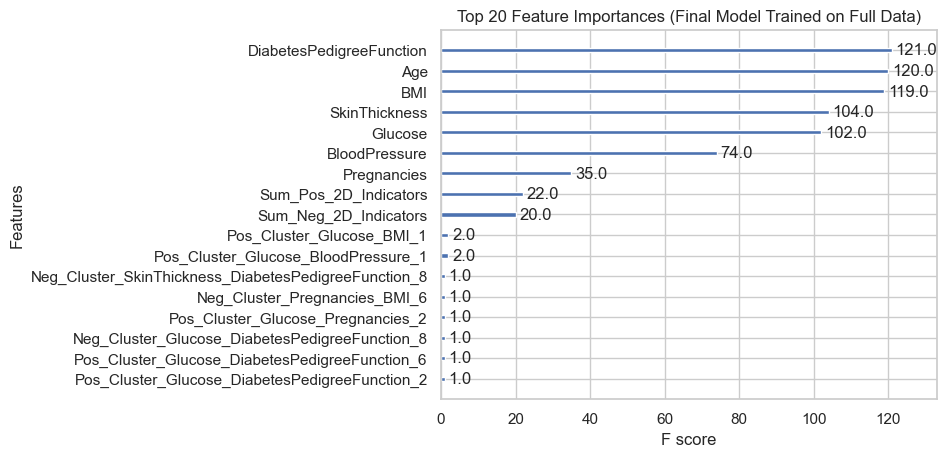

In [25]:
X_train_feature_interactions = X_train.copy()
X_test_feature_interactions = X_test.copy()

# add feature interactions
#X_train_feature_interactions = create_interaction_features(X_train_feature_interactions, ['Glucose', 'DiabetesPedigreeFunction'])#, 'SkinThickness', 'BMI', 'Age', 'Pregnancies', 'BloodPressure'])
#X_test_feature_interactions = create_interaction_features(X_test_feature_interactions, ['Glucose', 'DiabetesPedigreeFunction'])#, 'SkinThickness', 'BMI', 'Age', 'Pregnancies', 'BloodPressure'])

# drop Insulin
X_train_feature_interactions = X_train_feature_interactions.drop(columns=['Insulin'])
X_test_feature_interactions = X_test_feature_interactions.drop(columns=['Insulin'])


def objective_xgb(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 2.0),
        'n_estimators': trial.suggest_int('n_estimators', 30, 200),
    }

    # Initialize model
    model = xgb.XGBClassifier(**param)
    
    # Cross-validation settings
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    fbeta_scores = []
    
    for train_idx, val_idx in skf.split(X_train_feature_interactions, Y_train):
        # Use .iloc to index the DataFrame/Series by position
        X_train_cv, X_val_cv = X_train_feature_interactions.iloc[train_idx], X_train_feature_interactions.iloc[val_idx]
        Y_train_cv, Y_val_cv = Y_train.iloc[train_idx], Y_train.iloc[val_idx]

        model.fit(X_train_cv, Y_train_cv, eval_set=[(X_val_cv, Y_val_cv)], verbose=False)

        y_pred = model.predict(X_val_cv)

        # Calculate F1 and F-beta scores
        f1 = f1_score(Y_val_cv, y_pred)
        fbeta = fbeta_score(Y_val_cv, y_pred, beta=2)

        f1_scores.append(f1)
        fbeta_scores.append(fbeta)
    
    # Average F1 and F-beta scores
    avg_f1 = sum(f1_scores) / len(f1_scores)
    avg_fbeta = sum(fbeta_scores) / len(fbeta_scores)
    
    # You can return either the F1 or F-beta depending on what you need
    # For now, returning both for flexibility
    return avg_f1

## Commented out to not run Optuna every time. Best parameters copied below.
#study = optuna.create_study(direction='maximize')
#study.optimize(objective_xgb, n_trials=900)

#print(f'Best trial: {study.best_trial.params}')

best_params_xgb = {'learning_rate': 0.0938123250382309, 'max_depth': 4, 'min_child_weight': 3, 
                   'subsample': 0.6986355266356858, 'colsample_bytree': 0.6672673888057575,
                   'gamma': 0.5487876186889995, 'reg_alpha': 1.4124462422614297, 'reg_lambda': 1.3177389073051406, 'n_estimators': 144}
#best_params_xgb = study.best_trial.params


# see average performance of optimal hyperparameters
# Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store train and validation metrics for each fold
f1_scores_train = []
accuracy_scores_train = []
recall_scores_train = []
auc_scores_train = []

f1_scores_val = []
accuracy_scores_val = []
recall_scores_val = []
auc_scores_val = []

for train_idx, val_idx in skf.split(X_train_feature_interactions, Y_train):
    # Use .iloc to index the DataFrame/Series by position
    X_train_cv, X_val_cv = X_train_feature_interactions.iloc[train_idx], X_train_feature_interactions.iloc[val_idx]
    Y_train_cv, Y_val_cv = Y_train.iloc[train_idx], Y_train.iloc[val_idx]
    
    # Train model on current fold
    fold_model = xgb.XGBClassifier(**best_params_xgb)
    fold_model.fit(X_train_cv, Y_train_cv, verbose=False)
    
    # Predictions for training set
    y_train_pred = fold_model.predict(X_train_cv)
    y_train_probs = fold_model.predict_proba(X_train_cv)[:, 1]
    
    # Calculate training metrics
    f1_train = f1_score(Y_train_cv, y_train_pred)
    accuracy_train = accuracy_score(Y_train_cv, y_train_pred)
    recall_train = recall_score(Y_train_cv, y_train_pred)
    
    
    f1_scores_train.append(f1_train)
    accuracy_scores_train.append(accuracy_train)
    recall_scores_train.append(recall_train)
    
    
    # Predictions for validation set (current fold)
    y_val_pred = fold_model.predict(X_val_cv)
    y_val_probs = fold_model.predict_proba(X_val_cv)[:, 1]
    
    # Calculate validation metrics
    f1_val = f1_score(Y_val_cv, y_val_pred)
    accuracy_val = accuracy_score(Y_val_cv, y_val_pred)
    recall_val = recall_score(Y_val_cv, y_val_pred)
    
    
    f1_scores_val.append(f1_val)
    accuracy_scores_val.append(accuracy_val)
    recall_scores_val.append(recall_val)
    

# Average the scores over all folds
avg_f1_train = sum(f1_scores_train) / len(f1_scores_train)
avg_accuracy_train = sum(accuracy_scores_train) / len(accuracy_scores_train)
avg_recall_train = sum(recall_scores_train) / len(recall_scores_train)


avg_f1_val = sum(f1_scores_val) / len(f1_scores_val)
avg_accuracy_val = sum(accuracy_scores_val) / len(accuracy_scores_val)
avg_recall_val = sum(recall_scores_val) / len(recall_scores_val)


# Print average training performance
print(f"Cross-validated Training F1 Score: {avg_f1_train:.4f}")
print(f"Cross-validated Training Accuracy: {avg_accuracy_train:.4f}")
print(f"Cross-validated Training Recall: {avg_recall_train:.4f}\n")

# Print average validation performance
print(f"Cross-validated Validation F1 Score: {avg_f1_val:.4f}")
print(f"Cross-validated Validation Accuracy: {avg_accuracy_val:.4f}")
print(f"Cross-validated Validation Recall: {avg_recall_val:.4f}")

# Train the final model on the full training dataset with the best hyperparameters
final_model_xgb = xgb.XGBClassifier(**best_params_xgb)
final_model_xgb.fit(X_train_feature_interactions, Y_train)  # Train on full training data

# Plot feature importance based on the model trained on the entire dataset
xgb.plot_importance(final_model_xgb, importance_type='weight', max_num_features=20)
plt.title('Top 20 Feature Importances (Final Model Trained on Full Data)')
plt.show()

**Inference**

- Performance is much better than the baseline, with a **recall of 0.6667 and an F1 Score of 0.6862**. 
- Interesting to note the **importance of the DiabetesPedigreeFunction**. This confirms our intuition dveloped in EDA that a lot of cases will be determined in complex ways involving genetics.

### Improved Logistic Regression

The logistic regression we have as a dummy model is quite simplistic and serves as a quick heuristic to get a baseline level of performance. However, this does not mean that linear models cannot perform any better. There are a few things we can try to reach a better linear model.

Things tried:
- ❌ using all the features: worse F1 and recall
- ❌ adding all feature interactions 
- ✔️ using only the most important features from the XGBoost model (3 to all features tried, 8 optimal)
- ✔️ using **L1 regularization** - improved recall and F1 meaningfully.
- ❌ using L2 regularization - slight improvement on 
- ❌ using ElasticNet (L1+L2 with Optuna)


In [26]:
# Initialize the StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store the scores from each fold
f1_scores_cv = []
accuracy_scores_cv = []
recall_scores_cv = []

# Initialize the Logistic Regression model
full_lr = LogisticRegression()

# Perform 5-fold cross-validation
for train_idx, val_idx in skf.split(X_train, Y_train):
    # Split the data
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    Y_train_cv, Y_val_cv = Y_train.iloc[train_idx], Y_train.iloc[val_idx]
    
    # Train the model
    full_lr.fit(X_train_cv, Y_train_cv.values.ravel())
    
    # Make predictions on the validation set
    y_val_pred = full_lr.predict(X_val_cv)
    
    # Calculate the scores
    f1 = f1_score(Y_val_cv, y_val_pred)
    accuracy = accuracy_score(Y_val_cv, y_val_pred)
    recall = recall_score(Y_val_cv, y_val_pred)
    
    # Append the scores to the lists
    f1_scores_cv.append(f1)
    accuracy_scores_cv.append(accuracy)
    recall_scores_cv.append(recall)

# Calculate the average performance across the folds
avg_f1_cv = sum(f1_scores_cv) / len(f1_scores_cv)
avg_accuracy_cv = sum(accuracy_scores_cv) / len(accuracy_scores_cv)
avg_recall_cv = sum(recall_scores_cv) / len(recall_scores_cv)

# Print the average metrics across all folds
print("Metrics for first Logistic Regression with all features:")
print(f"Cross-validated F1 Score: {avg_f1_cv:.4f}")
print(f"Cross-validated Accuracy: {avg_accuracy_cv:.4f}")
print(f"Cross-validated Recall: {avg_recall_cv:.4f}")

Metrics for first Logistic Regression with all features:
Cross-validated F1 Score: 0.6087
Cross-validated Accuracy: 0.7637
Cross-validated Recall: 0.5379


In [27]:
# Get the XGB booster (underlying model)
booster = final_model_xgb.get_booster()

# Get feature importance by weight
importance = booster.get_score(importance_type='weight')

# Sort the features by importance score
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Extract the top N feature names
top_n_features = [feature for feature, score in sorted_importance[:8]]  # N tuned manually

print("Top N feature names:", top_n_features)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store cross-validated scores
f1_scores_cv = []
accuracy_scores_cv = []
recall_scores_cv = []

X_lr_train = X_train.copy()
X_lr_test = X_test.copy()

X_lr_train = create_interaction_features(X_lr_train, ['Glucose', 'DiabetesPedigreeFunction', 'SkinThickness', 'BMI', 'BloodPressure', 'Age', 'Pregnancies'])
X_lr_test = create_interaction_features(X_lr_test, ['Glucose', 'DiabetesPedigreeFunction', 'SkinThickness', 'BMI', 'BloodPressure', 'Age', 'Pregnancies'])

# Extract the top 13 features from the training data
X_train_top_n_features = X_lr_train[top_n_features]


# Initialize the Logistic Regression model
trial_lr = LogisticRegression()

# Perform 5-fold cross-validation
for train_idx, val_idx in skf.split(X_train_top_n_features, Y_train):
    # Split the data
    X_train_cv, X_val_cv = X_train_top_n_features.iloc[train_idx], X_train_top_n_features.iloc[val_idx]
    Y_train_cv, Y_val_cv = Y_train.iloc[train_idx], Y_train.iloc[val_idx]
    
    # Train the Logistic Regression model
    trial_lr.fit(X_train_cv, Y_train_cv.values.ravel())
    
    # Make predictions on the validation set
    y_val_pred = trial_lr.predict(X_val_cv)
    
    # Calculate the evaluation metrics
    f1 = f1_score(Y_val_cv, y_val_pred)
    accuracy = accuracy_score(Y_val_cv, y_val_pred)
    recall = recall_score(Y_val_cv, y_val_pred)
    
    # Append the metrics to the corresponding lists
    f1_scores_cv.append(f1)
    accuracy_scores_cv.append(accuracy)
    recall_scores_cv.append(recall)

# Average the scores across the folds
avg_f1_cv = sum(f1_scores_cv) / len(f1_scores_cv)
avg_accuracy_cv = sum(accuracy_scores_cv) / len(accuracy_scores_cv)
avg_recall_cv = sum(recall_scores_cv) / len(recall_scores_cv)

# Print the cross-validated metrics
print("Metrics for Logistic Regression with top N features:")
print(f"Cross-validated F1 Score: {avg_f1_cv:.4f}")
print(f"Cross-validated Accuracy: {avg_accuracy_cv:.4f}")
print(f"Cross-validated Recall: {avg_recall_cv:.4f}")

Top N feature names: ['DiabetesPedigreeFunction', 'Age', 'BMI', 'SkinThickness', 'Glucose', 'BloodPressure', 'Pregnancies', 'Sum_Pos_2D_Indicators']
Metrics for Logistic Regression with top N features:
Cross-validated F1 Score: 0.6274
Cross-validated Accuracy: 0.7706
Cross-validated Recall: 0.5626


In [28]:
## Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store cross-validated scores
f1_scores_cv = []
accuracy_scores_cv = []
recall_scores_cv = []

# Extract the top 10 features from the training data
X_train_top_n_features = X_train_feature_interactions[top_n_features]

# Initialize the Logistic Regression model with L1 regularization
trial_lr_l1 = LogisticRegression(penalty='l1', C=0.05, solver='liblinear', max_iter=1000)  #C tuned manually

# Perform 5-fold cross-validation
for train_idx, val_idx in skf.split(X_train_top_n_features, Y_train):
    # Split the data
    X_train_cv, X_val_cv = X_train_top_n_features.iloc[train_idx], X_train_top_n_features.iloc[val_idx]
    Y_train_cv, Y_val_cv = Y_train.iloc[train_idx], Y_train.iloc[val_idx]
    
    # Train the Logistic Regression model with L1 regularization
    trial_lr_l1.fit(X_train_cv, Y_train_cv.values.ravel())
    
    # Make predictions on the validation set
    y_val_pred_l1 = trial_lr_l1.predict(X_val_cv)
    
    # Calculate the evaluation metrics
    f1 = f1_score(Y_val_cv, y_val_pred_l1)
    accuracy = accuracy_score(Y_val_cv, y_val_pred_l1)
    recall = recall_score(Y_val_cv, y_val_pred_l1)
    
    # Append the metrics to the corresponding lists
    f1_scores_cv.append(f1)
    accuracy_scores_cv.append(accuracy)
    recall_scores_cv.append(recall)

# Average the scores across the folds
avg_f1_cv_l1 = sum(f1_scores_cv) / len(f1_scores_cv)
avg_accuracy_cv_l1 = sum(accuracy_scores_cv) / len(accuracy_scores_cv)
avg_recall_cv_l1 = sum(recall_scores_cv) / len(recall_scores_cv)

# Print the cross-validated metrics for L1 regularization
print("Metrics for Logistic Regression with top N features and L1 regularization:")
print(f"Cross-validated F1 Score (L1): {avg_f1_cv_l1:.4f}")
print(f"Cross-validated Accuracy (L1): {avg_accuracy_cv_l1:.4f}")
print(f"Cross-validated Recall (L1): {avg_recall_cv_l1:.4f}")

Metrics for Logistic Regression with top N features and L1 regularization:
Cross-validated F1 Score (L1): 0.6207
Cross-validated Accuracy (L1): 0.7689
Cross-validated Recall (L1): 0.5528


In [29]:
# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store cross-validated scores
f1_scores_cv = []
accuracy_scores_cv = []
recall_scores_cv = []

# Extract the top 13 features from the training data
X_train_top_n_features = X_train_feature_interactions[top_n_features]

# Initialize the Logistic Regression model with L2 regularization
trial_lr_l2 = LogisticRegression(penalty='l2', C=1, solver='liblinear', max_iter=1000)  #C tuned manually

# Perform 5-fold cross-validation
for train_idx, val_idx in skf.split(X_train_top_n_features, Y_train):
    # Split the data
    X_train_cv, X_val_cv = X_train_top_n_features.iloc[train_idx], X_train_top_n_features.iloc[val_idx]
    Y_train_cv, Y_val_cv = Y_train.iloc[train_idx], Y_train.iloc[val_idx]
    
    # Train the Logistic Regression model with L2 regularization
    trial_lr_l2.fit(X_train_cv, Y_train_cv.values.ravel())
    
    # Make predictions on the validation set
    y_val_pred_l2 = trial_lr_l2.predict(X_val_cv)
    
    # Calculate the evaluation metrics
    f1 = f1_score(Y_val_cv, y_val_pred_l2)
    accuracy = accuracy_score(Y_val_cv, y_val_pred_l2)
    recall = recall_score(Y_val_cv, y_val_pred_l2)
    
    # Append the metrics to the corresponding lists
    f1_scores_cv.append(f1)
    accuracy_scores_cv.append(accuracy)
    recall_scores_cv.append(recall)

# Average the scores across the folds
avg_f1_cv_l2 = sum(f1_scores_cv) / len(f1_scores_cv)
avg_accuracy_cv_l2 = sum(accuracy_scores_cv) / len(accuracy_scores_cv)
avg_recall_cv_l2 = sum(recall_scores_cv) / len(recall_scores_cv)

# Print the cross-validated metrics for L2 regularization
print("Metrics for Logistic Regression with top N features and L2 regularization:")
print(f"Cross-validated F1 Score (L2): {avg_f1_cv_l2:.4f}")
print(f"Cross-validated Accuracy (L2): {avg_accuracy_cv_l2:.4f}")
print(f"Cross-validated Recall (L2): {avg_recall_cv_l2:.4f}")

Metrics for Logistic Regression with top N features and L2 regularization:
Cross-validated F1 Score (L2): 0.6258
Cross-validated Accuracy (L2): 0.7689
Cross-validated Recall (L2): 0.5626


The optimized Logistic Regression model with L1 regularization has a cross-validated F1 score of 0.6578, accuracy of 0.7603, and recall of 0.6670, which comparable to the XGBoost results. 

This is encouraging given their different learning approaches. Logistic regression provides a more interpretable, linear decision boundary, while XGBoost captures non-linear relationships and feature interactions. This suggests that each model identifies distinct patterns, making them suitable candidates for an ensemble model. By combining them, we can potentially improve overall performance by leveraging the strengths of both methods, enhancing robustness and reducing overfitting.

### LightGBM

As an alternative to XGBoost, we will explore the tree-based algorithm LightGBM. This model differs primarily in its tree construction method; LightGBM grows trees leaf-wise rather than level-wise. This approach allows it to capture complex patterns and interactions in the data more effectively in certain cases. While both algorithms are powerful, the leaf-wise growth of LightGBM may offer different insights compared to the balanced structure of XGBoost.

<div style="text-align: center;">
    <img src="images/lightgbm.png" alt="Diabetes" width="500">
</div>

Here is a quick run down of what was tried:

- ✔️ using feature interactions: adding selected feature interactions improved F1, no drop on recall. 
- ❌ dropping the Insulin feature: made no meaningful difference. 
- ❌ using the F2 score for training: worse F1, slightly better recall, as could be expected


Training Metrics across CV folds:
Average F1: 0.8703
Average Accuracy: 0.9127
Average Recall: 0.8520
Average Fβ (β=2): 0.8592

Validation Metrics across CV folds:
Average F1: 0.6795
Average Accuracy: 0.7757
Average Recall: 0.6916
Average Fβ (β=2): 0.6856


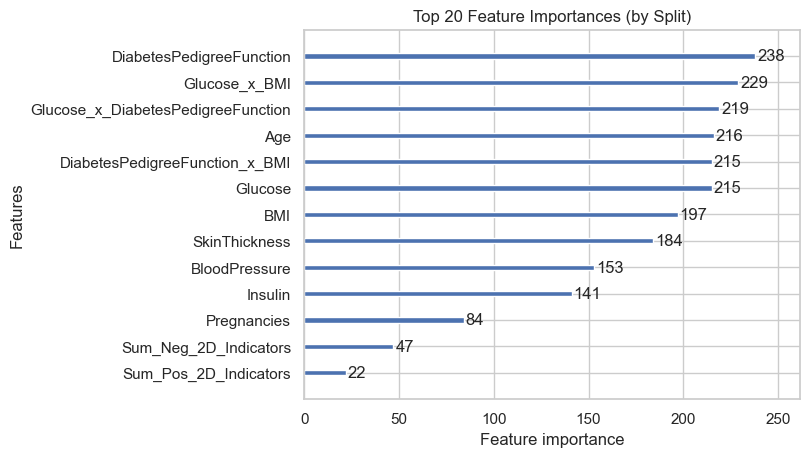

In [30]:
X_train_feature_interactions = X_train.copy()
X_test_feature_interactions = X_test.copy()

# add feature interactions
X_train_feature_interactions = create_interaction_features(X_train_feature_interactions, ['Glucose', 'DiabetesPedigreeFunction', 'BMI'])#, 'SkinThickness', 'BloodPressure', 'Age', 'Pregnancies'])
X_test_feature_interactions = create_interaction_features(X_test_feature_interactions, ['Glucose', 'DiabetesPedigreeFunction', 'BMI'])#, 'SkinThickness', 'BloodPressure', 'Age', 'Pregnancies'])

# drop Insulin
#X_train_feature_interactions = X_train_feature_interactions.drop(columns=['Insulin'])
#X_test_feature_interactions = X_test_feature_interactions.drop(columns=['Insulin'])

# Define function to calculate and print metrics
def print_cv_metrics(fold_metrics, name):
    print(f'\n{name} Metrics across CV folds:')
    print(f'Average F1: {sum(fold_metrics["f1"]) / len(fold_metrics["f1"]):.4f}')
    print(f'Average Accuracy: {sum(fold_metrics["accuracy"]) / len(fold_metrics["accuracy"]):.4f}')
    print(f'Average Recall: {sum(fold_metrics["recall"]) / len(fold_metrics["recall"]):.4f}')
    print(f'Average Fβ (β=2): {sum(fold_metrics["fbeta"]) / len(fold_metrics["fbeta"]):.4f}')

# Initialize cross-validation metrics
def initialize_metrics():
    return {'f1': [], 'accuracy': [], 'recall': [], 'fbeta': []}

# Objective function for Optuna
def objective_lgbm(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 30, 500),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 1e-8, 1.0, log=True),
        'max_bin': trial.suggest_int('max_bin', 128, 512),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 10, log=True),
        'verbosity': -1
    }

    # Perform 5-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    fbeta_scores = []

    for train_idx, val_idx in skf.split(X_train_feature_interactions, Y_train):
        X_train_cv, X_val_cv = X_train_feature_interactions.iloc[train_idx], X_train_feature_interactions.iloc[val_idx]
        Y_train_cv, Y_val_cv = Y_train.iloc[train_idx], Y_train.iloc[val_idx]

        # Train the model
        model = lgb.LGBMClassifier(**param)
        model.fit(X_train_cv, Y_train_cv.values.ravel())

        # Predict on validation set
        y_val_pred = model.predict(X_val_cv)
        
        # Calculate F1 score
        f1_scores.append(f1_score(Y_val_cv, y_val_pred))
        fbeta_scores.append(fbeta_score(Y_val_cv, y_val_pred, beta=2))

    # Return the average F1 score across the CV folds
    return sum(f1_scores) / len(f1_scores)

# Perform 5-fold CV with the best parameters and print train/test metrics
def cross_validate_with_best_params(best_params, X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    train_metrics = initialize_metrics()
    cv_metrics = initialize_metrics()

    for train_idx, val_idx in skf.split(X, y):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        Y_train_cv, Y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

        # Train the model
        model = lgb.LGBMClassifier(**best_params, verbosity=-1)
        model.fit(X_train_cv, Y_train_cv.values.ravel())

        # Predictions for training set
        y_train_pred = model.predict(X_train_cv)
        
        # Predictions for validation set
        y_val_pred = model.predict(X_val_cv)

        # Calculate metrics for training set
        train_metrics['f1'].append(f1_score(Y_train_cv, y_train_pred))
        train_metrics['accuracy'].append(accuracy_score(Y_train_cv, y_train_pred))
        train_metrics['recall'].append(recall_score(Y_train_cv, y_train_pred))
        train_metrics['fbeta'].append(fbeta_score(Y_train_cv, y_train_pred, beta=2))

        # Calculate metrics for validation set
        cv_metrics['f1'].append(f1_score(Y_val_cv, y_val_pred))
        cv_metrics['accuracy'].append(accuracy_score(Y_val_cv, y_val_pred))
        cv_metrics['recall'].append(recall_score(Y_val_cv, y_val_pred))
        cv_metrics['fbeta'].append(fbeta_score(Y_val_cv, y_val_pred, beta=2))

    # Print training and cross-validation metrics
    print_cv_metrics(train_metrics, "Training")
    print_cv_metrics(cv_metrics, "Validation")

# Train the final model on the entire dataset and plot feature importance
def train_final_model_and_plot_importance(best_params, X, y):
    final_model_lgb = lgb.LGBMClassifier(**best_params, verbosity=-1)
    final_model_lgb.fit(X, y.values.ravel())

    # Plot feature importance
    lgb.plot_importance(final_model_lgb, importance_type='split', max_num_features=20)
    plt.title('Top 20 Feature Importances (by Split)')
    plt.show()

# Run the Optuna study to optimize the objective function
#study = optuna.create_study(direction='maximize')
#study.optimize(objective_lgbm, n_trials=900)

# Get the best parameters from Optuna
#best_params_lgb = study.best_trial.params
#print(f'Best parameters found by Optuna: {best_params_lgb}')

best_params_lgb = {'boosting_type': 'gbdt', 'learning_rate': 0.038825952510385994, 'n_estimators': 456, 'num_leaves': 112, 'max_depth': 5, 'min_data_in_leaf': 39, 'lambda_l1': 0.2931380206819117, 'lambda_l2': 7.812968405466895e-07, 'bagging_fraction': 0.4973644767138976, 'bagging_freq': 1, 'feature_fraction': 0.8538793416810394, 'min_split_gain': 0.05136851634739611, 'max_bin': 272, 'min_child_weight': 2.4484177551297166e-05}
# Perform 5-fold CV with best parameters and print metrics
cross_validate_with_best_params(best_params_lgb, X_train_feature_interactions, Y_train)

# Train the final model on the entire dataset and plot feature importance
train_final_model_and_plot_importance(best_params_lgb, X_train_feature_interactions, Y_train)

**Inference**:
- **Better Recall**: LightGBM outperformed XGBoost for recall, but did slighlty worse on F1.
- **DiabetesPedigreeFunction**: Once again, we can highlight the importance of the `DiabetesPedigreeFunction` feature, reinforcing the hypothesis that genetics play an important role in diabetes risk.

### Other Models

Here is a list of other models that were also explored, but had lower performance:

- ❌ KNN
- ❌ CatBoost
- ❌ SVM

### Ensemble Model

In [31]:
def objective_ensemble(trial, X_train, Y_train):
    # Suggest weights for each base model
    weight_xgb = trial.suggest_float('weight_xgb', 0, 1)
    weight_lgb = trial.suggest_float('weight_lgb', 0, 1)
    weight_lr = trial.suggest_float('weight_lr', 0, 1)

    # Normalize weights to sum to 1
    total_weight = weight_xgb + weight_lgb + weight_lr
    weight_xgb /= total_weight
    weight_lgb /= total_weight
    weight_lr /= total_weight

    f1_scores = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_train, Y_train):
        # Split the data into training and validation
        X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
        Y_train_cv, Y_val_cv = Y_train.iloc[train_idx], Y_train.iloc[val_idx]

        # Prepare features for each model
        X_train_xgb = X_train_cv.drop(columns=['Insulin']).copy()
        X_val_xgb = X_val_cv.drop(columns=['Insulin']).copy()

        X_train_lgb = create_interaction_features(X_train_cv.copy(), ['Glucose', 'DiabetesPedigreeFunction', 'BMI'])
        X_val_lgb = create_interaction_features(X_val_cv.copy(), ['Glucose', 'DiabetesPedigreeFunction', 'BMI'])

        X_train_lr = X_train_cv[['DiabetesPedigreeFunction', 'Age', 'BMI', 'Glucose', 
                                 'BloodPressure', 'SkinThickness', 'Pregnancies', 
                                 'Sum_Neg_2D_Indicators']].copy()
        X_val_lr = X_val_cv[['DiabetesPedigreeFunction', 'Age', 'BMI', 'Glucose', 
                             'BloodPressure', 'SkinThickness', 'Pregnancies', 
                             'Sum_Neg_2D_Indicators']].copy()

        # Train base models
        xgb_model = xgb.XGBClassifier(**best_params_xgb, verbosity=0, random_state=42)
        lgb_model = lgb.LGBMClassifier(**best_params_lgb, verbosity=-1, random_state=42)
        lr_model = LogisticRegression(penalty='l1', C=0.05, solver='liblinear', max_iter=1000)

        xgb_model.fit(X_train_xgb, Y_train_cv.values.ravel())
        lgb_model.fit(X_train_lgb, Y_train_cv.values.ravel())
        lr_model.fit(X_train_lr, Y_train_cv.values.ravel())

        # Make predictions
        preds_xgb = xgb_model.predict_proba(X_val_xgb)[:, 1]
        preds_lgb = lgb_model.predict_proba(X_val_lgb)[:, 1]
        preds_lr = lr_model.predict_proba(X_val_lr)[:, 1]

        # Weighted average of predictions
        final_preds_proba = (weight_xgb * preds_xgb + weight_lgb * preds_lgb + weight_lr * preds_lr)
        final_preds = (final_preds_proba > 0.5).astype(int)

        # Calculate F1 score
        f1_scores.append(f1_score(Y_val_cv, final_preds))

    return np.mean(f1_scores)

# study = optuna.create_study(direction='maximize')
# study.optimize(lambda trial: objective_ensemble(trial, X_train, Y_train), n_trials=100)

# # Best weights
# best_weights = study.best_trial.params
# print("Best weights found by Optuna:", best_weights)
best_weights = {'weight_xgb': 0.16040322045148647, 'weight_lgb': 0.01543005230664063, 'weight_lr': 0.4369949790968489}

def evaluate_weighted_average(weights, X, y):
    weight_xgb = weights['weight_xgb']
    weight_lgb = weights['weight_lgb']
    weight_lr = weights['weight_lr']

    # Normalize weights
    total_weight = weight_xgb + weight_lgb + weight_lr
    weight_xgb /= total_weight
    weight_lgb /= total_weight
    weight_lr /= total_weight

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_metrics = initialize_metrics()

    for train_idx, val_idx in skf.split(X, y):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        Y_train_cv, Y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

        # Prepare features for each model
        X_train_xgb = X_train_cv.drop(columns=['Insulin']).copy()
        X_val_xgb = X_val_cv.drop(columns=['Insulin']).copy()

        X_train_lgb = create_interaction_features(X_train_cv.copy(), ['Glucose', 'DiabetesPedigreeFunction', 'BMI'])
        X_val_lgb = create_interaction_features(X_val_cv.copy(), ['Glucose', 'DiabetesPedigreeFunction', 'BMI'])

        X_train_lr = X_train_cv[['DiabetesPedigreeFunction', 'Age', 'BMI', 'Glucose', 
                                 'BloodPressure', 'SkinThickness', 'Pregnancies', 
                                 'Sum_Neg_2D_Indicators']].copy()
        X_val_lr = X_val_cv[['DiabetesPedigreeFunction', 'Age', 'BMI', 'Glucose', 
                             'BloodPressure', 'SkinThickness', 'Pregnancies', 
                             'Sum_Neg_2D_Indicators']].copy()

        # Train base models
        xgb_model = xgb.XGBClassifier(**best_params_xgb, verbosity=0, random_state=42)
        lgb_model = lgb.LGBMClassifier(**best_params_lgb, verbosity=-1, random_state=42)
        lr_model = LogisticRegression(penalty='l1', C=0.05, solver='liblinear', max_iter=1000)

        xgb_model.fit(X_train_xgb, Y_train_cv.values.ravel())
        lgb_model.fit(X_train_lgb, Y_train_cv.values.ravel())
        lr_model.fit(X_train_lr, Y_train_cv.values.ravel())

        # Make predictions
        preds_xgb = xgb_model.predict_proba(X_val_xgb)[:, 1]
        preds_lgb = lgb_model.predict_proba(X_val_lgb)[:, 1]
        preds_lr = lr_model.predict_proba(X_val_lr)[:, 1]

        # Weighted average of predictions
        final_preds_proba = (weight_xgb * preds_xgb + weight_lgb * preds_lgb + weight_lr * preds_lr)
        final_preds = (final_preds_proba > 0.5).astype(int)

        # Calculate metrics
        cv_metrics['f1'].append(f1_score(Y_val_cv, final_preds))
        cv_metrics['accuracy'].append(accuracy_score(Y_val_cv, final_preds))
        cv_metrics['recall'].append(recall_score(Y_val_cv, final_preds))
        cv_metrics['fbeta'].append(fbeta_score(Y_val_cv, final_preds, beta=2))

    # Print metrics
    print_cv_metrics(cv_metrics, "Validation")

# Evaluate the ensemble with the best weights
evaluate_weighted_average(best_weights, X_train, Y_train)


Validation Metrics across CV folds:
Average F1: 0.6810
Average Accuracy: 0.7809
Average Recall: 0.6767
Average Fβ (β=2): 0.6778


The ensemble did not improve the performance. However, latency is not critical for this application, therefore it can still be a useful option to improve robustness.

## Evaluating Performance of Final Model on Test Data

In [32]:
# Train the final weighted average ensemble and evaluate on the test set
def train_final_ensemble(best_weights, X_train, Y_train, X_test, Y_test):
    # Prepare datasets for each model
    X_train_xgb = X_train.copy().drop(columns=['Insulin'])
    X_train_lr = X_train[['DiabetesPedigreeFunction', 'Age', 'BMI', 'Glucose', 
                          'BloodPressure', 'SkinThickness', 'Pregnancies', 'Sum_Neg_2D_Indicators']].copy()
    X_train_lgb = create_interaction_features(X_train.copy(), ['Glucose', 'DiabetesPedigreeFunction', 'BMI'])

    X_test_xgb = X_test.copy().drop(columns=['Insulin'])
    X_test_lr = X_test[['DiabetesPedigreeFunction', 'Age', 'BMI', 'Glucose', 
                        'BloodPressure', 'SkinThickness', 'Pregnancies', 'Sum_Neg_2D_Indicators']].copy()
    X_test_lgb = create_interaction_features(X_test.copy(), ['Glucose', 'DiabetesPedigreeFunction', 'BMI'])

    # Train models on the full training set
    xgb_model = xgb.XGBClassifier(**best_params_xgb, verbosity=0, random_state=42)
    lgb_model = lgb.LGBMClassifier(**best_params_lgb, verbosity=-1, random_state=42)
    lr_model = LogisticRegression(penalty='l1', C=0.05, solver='liblinear', max_iter=1000)

    xgb_model.fit(X_train_xgb, Y_train.values.ravel())
    lgb_model.fit(X_train_lgb, Y_train.values.ravel())
    lr_model.fit(X_train_lr, Y_train.values.ravel())

    # Make predictions (probabilities) on the test set
    preds_xgb = xgb_model.predict_proba(X_test_xgb)[:, 1]
    preds_lgb = lgb_model.predict_proba(X_test_lgb)[:, 1]
    preds_lr = lr_model.predict_proba(X_test_lr)[:, 1]

    # Normalize weights
    total_weight = best_weights['weight_xgb'] + best_weights['weight_lgb'] + best_weights['weight_lr']
    weight_xgb = best_weights['weight_xgb'] / total_weight
    weight_lgb = best_weights['weight_lgb'] / total_weight
    weight_lr = best_weights['weight_lr'] / total_weight

    # Weighted average of predictions
    final_preds_proba = (weight_xgb * preds_xgb + weight_lgb * preds_lgb + weight_lr * preds_lr)
    final_preds_test = (final_preds_proba > 0.5).astype(int)

    # Calculate test metrics
    f1_test = f1_score(Y_test, final_preds_test)
    accuracy_test = accuracy_score(Y_test, final_preds_test)
    recall_test = recall_score(Y_test, final_preds_test)
    fbeta_test = fbeta_score(Y_test, final_preds_test, beta=2)

    print(f'Test Metrics: F1 = {f1_test:.4f}, Accuracy = {accuracy_test:.4f}, Recall = {recall_test:.4f}, Fβ (β=2) = {fbeta_test:.4f}')
    
# Example weights from Optuna
best_weights = {'weight_xgb': 0.16040322045148647, 'weight_lgb': 0.01543005230664063, 'weight_lr': 0.4369949790968489}

# Train final ensemble on the entire dataset and evaluate on test set
train_final_ensemble(best_weights, X_train, Y_train, X_test, Y_test)

Test Metrics: F1 = 0.6667, Accuracy = 0.7742, Recall = 0.6512, Fβ (β=2) = 0.6573


The model generalized relatively well to the unseen test data, with similar F1 score and higher recall on the test set. 

We will now save the models for later use.

## Saving Models

In [35]:
import joblib
import os

def train_and_save_models(X, Y, best_params_xgb, best_params_lgb, best_weights, save_path="models/"):
    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)

    # Prepare datasets for each model
    X_xgb = X.drop(columns=['Insulin']).copy()
    X_lr = X[['DiabetesPedigreeFunction', 'Age', 'BMI', 'Glucose', 
              'BloodPressure', 'SkinThickness', 'Pregnancies', 'Sum_Neg_2D_Indicators']].copy()
    X_lgb = create_interaction_features(X.copy(), ['Glucose', 'DiabetesPedigreeFunction', 'BMI'])

    # Train models on the full dataset
    print("Training XGBoost model...")
    xgb_model = xgb.XGBClassifier(**best_params_xgb, verbosity=0, random_state=42)
    xgb_model.fit(X_xgb, Y.values.ravel())

    print("Training LightGBM model...")
    lgb_model = lgb.LGBMClassifier(**best_params_lgb, verbosity=-1, random_state=42)
    lgb_model.fit(X_lgb, Y.values.ravel())

    print("Training Logistic Regression model...")
    lr_model = LogisticRegression(penalty='l1', C=0.05, solver='liblinear', max_iter=1000, random_state=42)
    lr_model.fit(X_lr, Y.values.ravel())

    # Save models
    print("Saving models...")
    joblib.dump(xgb_model, f"{save_path}xgb_model.pkl")
    joblib.dump(lgb_model, f"{save_path}lgb_model.pkl")
    joblib.dump(lr_model, f"{save_path}lr_model.pkl")

    # Save model features
    joblib.dump(X_xgb.columns.tolist(), 'models/xgb_features.pkl')
    joblib.dump(X_lgb.columns.tolist(), 'models/lgb_features.pkl')
    joblib.dump(X_lr.columns.tolist(), 'models/lr_features.pkl')

    # Save model parameters
    print("Saving model parameters...")
    joblib.dump(best_params_xgb, f"{save_path}xgb_params.pkl")
    joblib.dump(best_params_lgb, f"{save_path}lgb_params.pkl")

    # Save weights for the weighted average ensemble
    print("Saving ensemble weights...")
    joblib.dump(best_weights, f"{save_path}ensemble_weights.pkl")

    print("All models, parameters, and weights have been saved successfully!")

# Combine training and test sets
X_all = pd.concat([X_train, X_test], ignore_index=True)
Y_all = pd.concat([Y_train, Y_test], ignore_index=True)

best_params_xgb = {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}
best_params_lgb = {'n_estimators': 120, 'max_depth': 6, 'learning_rate': 0.05}
best_weights = {'weight_xgb': 0.5, 'weight_lgb': 0.3, 'weight_lr': 0.2}

# Train and save all models
train_and_save_models(X_all, Y_all, best_params_xgb, best_params_lgb, best_weights, save_path="models/")


Training XGBoost model...
Training LightGBM model...
Training Logistic Regression model...
Saving models...
Saving model parameters...
Saving ensemble weights...
All models, parameters, and weights have been saved successfully!
